In [1]:
# !sudo apt-get update
# !sudo apt-get install python3-rtree
# !sudo pip3 install -U geopandas descartes pandas matplotlib
# !sudo pip3 install -U shapely

In [2]:
from datetime import datetime

t_start = datetime.now()

t_start

datetime.datetime(2019, 7, 14, 21, 58, 12, 566486)

In [3]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
!curl 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' -o accidents.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  321M    0  321M    0     0  2492k      0 --:--:--  0:02:11 --:--:-- 2366k


In [5]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv("accidents.csv", low_memory=False, dtype='object')
df['DATETIME'] = df.DATE + ' ' + df.TIME
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M")

In [6]:
!rm accidents.csv

In [7]:
df.rename(
    {
    "ZIP CODE" : 'ZIPCODE',
    "NUMBER OF PERSONS INJURED": "PERSONS_INJURED",
    "NUMBER OF PERSONS KILLED": "PERSONS_KILLED",
    "NUMBER OF PEDESTRIANS INJURED": "PEDESTRIANS_INJURED",
    "NUMBER OF PEDESTRIANS KILLED": "PEDESTRIANS_KILLED",
    'NUMBER OF MOTORIST INJURED': 'MOTORISTS_INJURED',
    'NUMBER OF MOTORIST KILLED': 'MOTORISTS_KILLED', 
    'NUMBER OF CYCLIST INJURED': 'CYCLISTS_INJURED', 
    'NUMBER OF CYCLIST KILLED': 'CYCLISTS_KILLED',
    'CONTRIBUTING FACTOR VEHICLE 1': 'CAUSE_VEHICLE_1',
    'CONTRIBUTING FACTOR VEHICLE 2': 'CAUSE_VEHICLE_2',
    'CONTRIBUTING FACTOR VEHICLE 3': 'CAUSE_VEHICLE_3',
    'CONTRIBUTING FACTOR VEHICLE 4': 'CAUSE_VEHICLE_4',
    'CONTRIBUTING FACTOR VEHICLE 5': 'CAUSE_VEHICLE_5',
    'VEHICLE TYPE CODE 1': 'TYPE_VEHICLE_1',
    'VEHICLE TYPE CODE 2': 'TYPE_VEHICLE_2',
    'VEHICLE TYPE CODE 3': 'TYPE_VEHICLE_3',
    'VEHICLE TYPE CODE 4': 'TYPE_VEHICLE_4',
    'VEHICLE TYPE CODE 5': 'TYPE_VEHICLE_5',
    },
    axis = 'columns',
    inplace = True
)

In [8]:
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_'))
df.columns = cols

In [9]:
cols = [
    'UNIQUE_KEY',
    'DATETIME',
    'BOROUGH',
    'ZIPCODE',
    'LATITUDE',
    'LONGITUDE',
    'LOCATION',
    'ON_STREET_NAME',
    'CROSS_STREET_NAME',
    'OFF_STREET_NAME',
    'PERSONS_INJURED',
    'PERSONS_KILLED',
    'PEDESTRIANS_INJURED',
    'PEDESTRIANS_KILLED',
    'CYCLISTS_INJURED',
    'CYCLISTS_KILLED',
    'MOTORISTS_INJURED',
    'MOTORISTS_KILLED',
    'CAUSE_VEHICLE_1',
    'CAUSE_VEHICLE_2',
    'CAUSE_VEHICLE_3',
    'CAUSE_VEHICLE_4',
    'CAUSE_VEHICLE_5',
    'TYPE_VEHICLE_1',
    'TYPE_VEHICLE_2',
    'TYPE_VEHICLE_3',
    'TYPE_VEHICLE_4',
    'TYPE_VEHICLE_5',
]

df = df[cols].copy()

In [10]:
df.dtypes

UNIQUE_KEY                     object
DATETIME               datetime64[ns]
BOROUGH                        object
ZIPCODE                        object
LATITUDE                       object
LONGITUDE                      object
LOCATION                       object
ON_STREET_NAME                 object
CROSS_STREET_NAME              object
OFF_STREET_NAME                object
PERSONS_INJURED                object
PERSONS_KILLED                 object
PEDESTRIANS_INJURED            object
PEDESTRIANS_KILLED             object
CYCLISTS_INJURED               object
CYCLISTS_KILLED                object
MOTORISTS_INJURED              object
MOTORISTS_KILLED               object
CAUSE_VEHICLE_1                object
CAUSE_VEHICLE_2                object
CAUSE_VEHICLE_3                object
CAUSE_VEHICLE_4                object
CAUSE_VEHICLE_5                object
TYPE_VEHICLE_1                 object
TYPE_VEHICLE_2                 object
TYPE_VEHICLE_3                 object
TYPE_VEHICLE

## Analysis of Data Types

### Datetime

In [11]:
# df['DATETIME'] = df.DATE + ' ' + df.TIME
# df.DATETIME = pd.to_datetime(df.DATETIME, format="%m/%d/%Y %H:%M")
#df.TIME = pd.to_datetime(df.TIME, format="%H:%M")
#df.DATE = pd.to_datetime(df.DATE, format="%m/%d/%Y")

In [12]:
# df['DATETIME'].hist(bins=7*12, figsize=(15,10))

In [13]:
# df.drop( ['DATE','TIME'], axis='columns', inplace=True)

### Borough

In [14]:
df['BOROUGH'] = pd.Categorical(df.BOROUGH)

In [15]:
df['BOROUGH'].value_counts()

BROOKLYN         331881
QUEENS           283986
MANHATTAN        259235
BRONX            148078
STATEN ISLAND     47404
Name: BOROUGH, dtype: int64

In [16]:
sum(~df['BOROUGH'].isnull())

1070584

In [17]:
# Significant number of missing values
# We will fix later, by joining with the NYC neighborhood shapefile
sum(df['BOROUGH'].isnull())

460772

### Zip Code

In [18]:
df['ZIPCODE'] = pd.Categorical(df['ZIPCODE'])

In [19]:
# Significant number of missing values
# We will fix later, by joining with the NYC ZIP shapefile
sum(df['ZIPCODE'].isnull())

460954

In [20]:
# We will get back to these columns with geo-shapefiles

### Longitute and Latitude

In [21]:
df.LATITUDE = pd.to_numeric(df.LATITUDE)
df.LONGITUDE  = pd.to_numeric(df.LONGITUDE)

In [22]:
sum(df['LATITUDE'].isnull() | df['LONGITUDE'].isnull())

190207

In [23]:
df['LATITUDE'].fillna(0.0, inplace=True)
df['LONGITUDE'].fillna(0.0, inplace=True)

# We keep LOCATION (which is largely redundant), just to make easy
# analysis of errors later on. 
df.LOCATION = '(' + df.LATITUDE.astype(float).astype(str) + ', ' + df.LONGITUDE.astype(float).astype(str) + ')'

# This is just lon/lat combined, we could drop it, but we will drop it later
# df.drop( ['LOCATION'], axis='columns', inplace=True)

### Numeric Fields

In [24]:
# df['UNIQUE_KEY'] = pd.to_numeric(df['UNIQUE_KEY'], downcast='unsigned')

In [25]:
df['PERSONS_INJURED'].fillna(0, inplace=True)
df['PERSONS_INJURED'] = pd.to_numeric(df['PERSONS_INJURED'], downcast='unsigned')

In [26]:
df['PERSONS_KILLED'].fillna(0, inplace=True)
df['PERSONS_KILLED']  = pd.to_numeric(df['PERSONS_KILLED'], downcast='unsigned')

In [27]:
df['PEDESTRIANS_INJURED'].fillna(0, inplace=True)
df['PEDESTRIANS_INJURED'] = pd.to_numeric(df['PEDESTRIANS_INJURED'], downcast='unsigned')

In [28]:
df['PEDESTRIANS_KILLED'].fillna(0, inplace=True)
df['PEDESTRIANS_KILLED'] = pd.to_numeric(df['PEDESTRIANS_KILLED'], downcast='unsigned')

In [29]:
df['CYCLISTS_INJURED'].fillna(0, inplace=True)
df['CYCLISTS_INJURED'] = pd.to_numeric(df['CYCLISTS_INJURED'], downcast='unsigned')

In [30]:
df['CYCLISTS_KILLED'].fillna(0, inplace=True)
df['CYCLISTS_KILLED'] = pd.to_numeric(df['CYCLISTS_KILLED'], downcast='unsigned')

In [31]:
df['MOTORISTS_INJURED'].fillna(0, inplace=True)
df['MOTORISTS_INJURED'] = pd.to_numeric(df['MOTORISTS_INJURED'], downcast='unsigned')

In [32]:
df['MOTORISTS_KILLED'].fillna(0, inplace=True)
df['MOTORISTS_KILLED'] = pd.to_numeric(df['MOTORISTS_KILLED'], downcast='unsigned')

## Normalizing Causes and Types

In [33]:
df['CAUSE_VEHICLE_1'] = pd.Categorical(df['CAUSE_VEHICLE_1'].str.upper())
df['CAUSE_VEHICLE_2'] = pd.Categorical(df['CAUSE_VEHICLE_2'].str.upper())
df['CAUSE_VEHICLE_3'] = pd.Categorical(df['CAUSE_VEHICLE_3'].str.upper())
df['CAUSE_VEHICLE_4'] = pd.Categorical(df['CAUSE_VEHICLE_4'].str.upper())
df['CAUSE_VEHICLE_5'] = pd.Categorical(df['CAUSE_VEHICLE_5'].str.upper())
df['TYPE_VEHICLE_1'] = pd.Categorical(df['TYPE_VEHICLE_1'].str.upper())
df['TYPE_VEHICLE_2'] = pd.Categorical(df['TYPE_VEHICLE_2'].str.upper())
df['TYPE_VEHICLE_3'] = pd.Categorical(df['TYPE_VEHICLE_3'].str.upper())
df['TYPE_VEHICLE_4'] = pd.Categorical(df['TYPE_VEHICLE_4'].str.upper())
df['TYPE_VEHICLE_5'] = pd.Categorical(df['TYPE_VEHICLE_5'].str.upper())


In [34]:
import numpy as np
df1 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_1', 'TYPE_VEHICLE_1']].copy()
df1['VEHICLE'] = 1
df1.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df2 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_2', 'TYPE_VEHICLE_2']].copy()
df2['VEHICLE'] = 2
df2.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df3 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_3', 'TYPE_VEHICLE_3']].copy()
df3['VEHICLE'] = 3
df3.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df4 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_4', 'TYPE_VEHICLE_4']].copy()
df4['VEHICLE'] = 4
df4.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']

df5 = df[['UNIQUE_KEY', 'CAUSE_VEHICLE_5', 'TYPE_VEHICLE_5']].copy()
df5['VEHICLE'] = 5
df5.columns = ['UNIQUE_KEY', 'CAUSE', 'VEHICLE_TYPE', 'VEHICLE']



In [35]:
concat_df = [df1, df2, df3, df4, df5]
ct_df = pd.concat(concat_df)
ct_df = ct_df.set_index('UNIQUE_KEY')
ct_df = ct_df.sort_values(['UNIQUE_KEY', 'VEHICLE'])
ct_df = ct_df.dropna()

In [36]:
# ct_df['CAUSE'] = pd.Categorical(ct_df['CAUSE'])
# ct_df['VEHICLE_TYPE'] = pd.Categorical(ct_df['VEHICLE_TYPE'])
# ct_df['VEHICLE'] = pd.Categorical(ct_df['VEHICLE'])

In [37]:
# Since we have the ct_df ("causes/types dataframe") we can drop these columns
# from the main dataframe
todrop = [
    'CAUSE_VEHICLE_1', 'TYPE_VEHICLE_1', 
    'CAUSE_VEHICLE_2', 'TYPE_VEHICLE_2',
    'CAUSE_VEHICLE_3', 'TYPE_VEHICLE_3', 
    'CAUSE_VEHICLE_4', 'TYPE_VEHICLE_4',
    'CAUSE_VEHICLE_5', 'TYPE_VEHICLE_5'
]
df.drop(todrop, axis='columns', inplace=True)

## Detecting Inconsistencies

In [38]:
# Incorrect number for injured people
check = (df.PEDESTRIANS_INJURED + df.CYCLISTS_INJURED + df.MOTORISTS_INJURED != df.PERSONS_INJURED)
incorrect_injured = set(df[check].UNIQUE_KEY.values)
len(incorrect_injured)

387

In [39]:
# Incorrect number of people killed
check = ( df.PEDESTRIANS_KILLED + df.CYCLISTS_KILLED + df.MOTORISTS_KILLED != df.PERSONS_KILLED)
incorrect_killed = set(df[check].UNIQUE_KEY.values)
len(incorrect_killed)

8

In [40]:
# No entries for vehicle/cause
nocause = set(df.UNIQUE_KEY.values) -set(ct_df.index.values)
len(nocause)

7287

In [41]:
# Incorrect number of entries for vehicle types/causes 
dd1 = ct_df[['VEHICLE']].groupby('UNIQUE_KEY').count() # number of vehicles involved
dd2 = ct_df[['VEHICLE']].groupby('UNIQUE_KEY').max() # higher number of VEHICLE_NUM
j = dd1.merge(dd2, left_index=True, right_index=True)
j.columns = ['cnt', 'max']
# j.query("cnt != max")

incorrect_vehicles = set(j.query("cnt != max").index.values)
len(incorrect_vehicles)

4

In [42]:
todelete = incorrect_injured | incorrect_killed | nocause | incorrect_vehicles

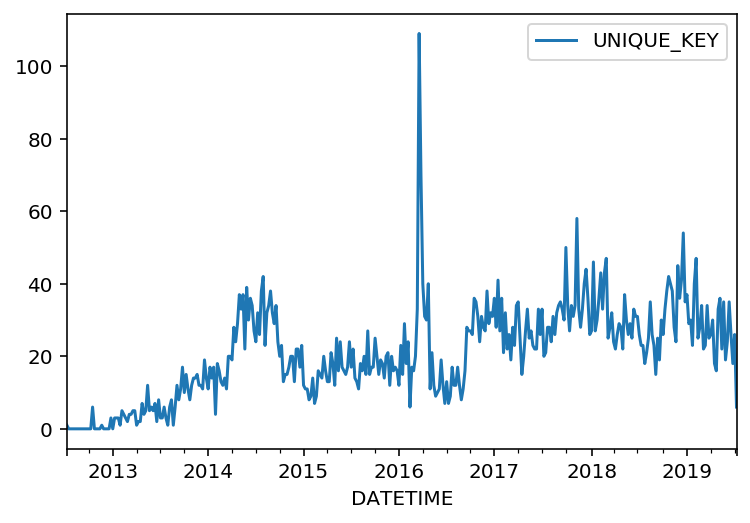

In [43]:
df[ df.UNIQUE_KEY.isin(todelete) ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

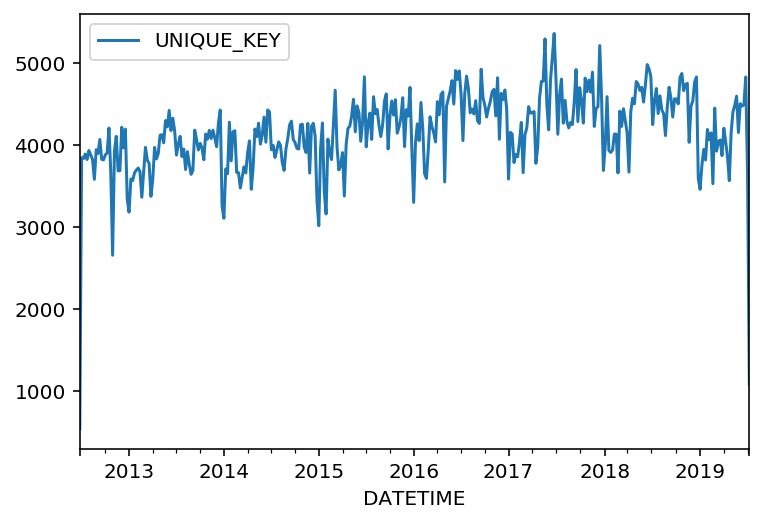

In [44]:
df.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [45]:
df = df[ ~df.UNIQUE_KEY.isin(todelete) ].copy()

## Lon/lat analysis, plus zipcode/borough

In [46]:
# The 'mask' sets rough bound box limits for NYC
mask = (df.LATITUDE > 40) & (df.LATITUDE < 41) & (df.LONGITUDE < -72) & (df.LONGITUDE > -74.5)


In [47]:
len(df[ ~mask ])

190538

In [48]:
len(df[ mask ])

1333185

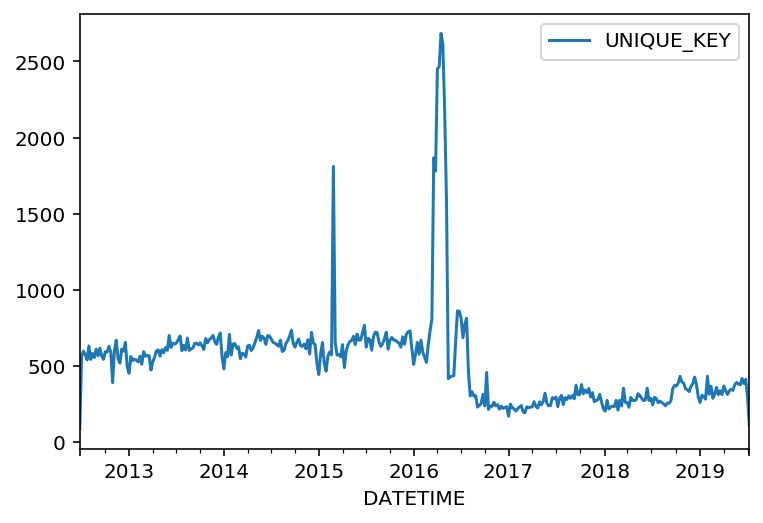

In [49]:
# Check if there is a temporal pattern in the errors
# where lon/lat are clearly not within NYC boundaries
# They are mostly missing ie. location = (0.0,0.0)
# The spikes are visible for the period of Mar-May 2016
# While we will drop these, it would be good to re-examine
# these later on
df[ ~mask ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

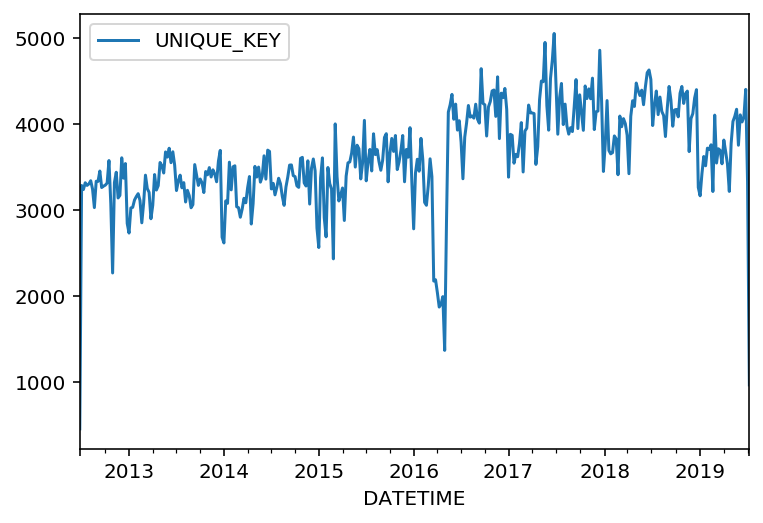

In [50]:
# We have a dillema here: If we drop the incorrect lon/lat values
# then we introduce clear abnormalities in the number of accidents over time
df[ mask ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [51]:
# FIXABLE error
# We have lon/lat within the NYC boundaries, but no borough
len(df[ mask & df.BOROUGH.isnull()])

296199

In [52]:
# FIXABLE error
# We have lon/lat within the NYC boundaries, but no ZIP
len(df[ mask & df.ZIPCODE.isnull()])

296364

In [53]:
# No cases where BOROUGH is null but zipcode is not
df[ df.BOROUGH.isnull() & ~df.ZIPCODE.isnull()]

Empty DataFrame
Columns: [UNIQUE_KEY, DATETIME, BOROUGH, ZIPCODE, LATITUDE, LONGITUDE, LOCATION, ON_STREET_NAME, CROSS_STREET_NAME, OFF_STREET_NAME, PERSONS_INJURED, PERSONS_KILLED, PEDESTRIANS_INJURED, PEDESTRIANS_KILLED, CYCLISTS_INJURED, CYCLISTS_KILLED, MOTORISTS_INJURED, MOTORISTS_KILLED]
Index: []

In [54]:
# Small number of cases where the borough is missing but not zip
len(df[ ~df.BOROUGH.isnull() & df.ZIPCODE.isnull() ])

181

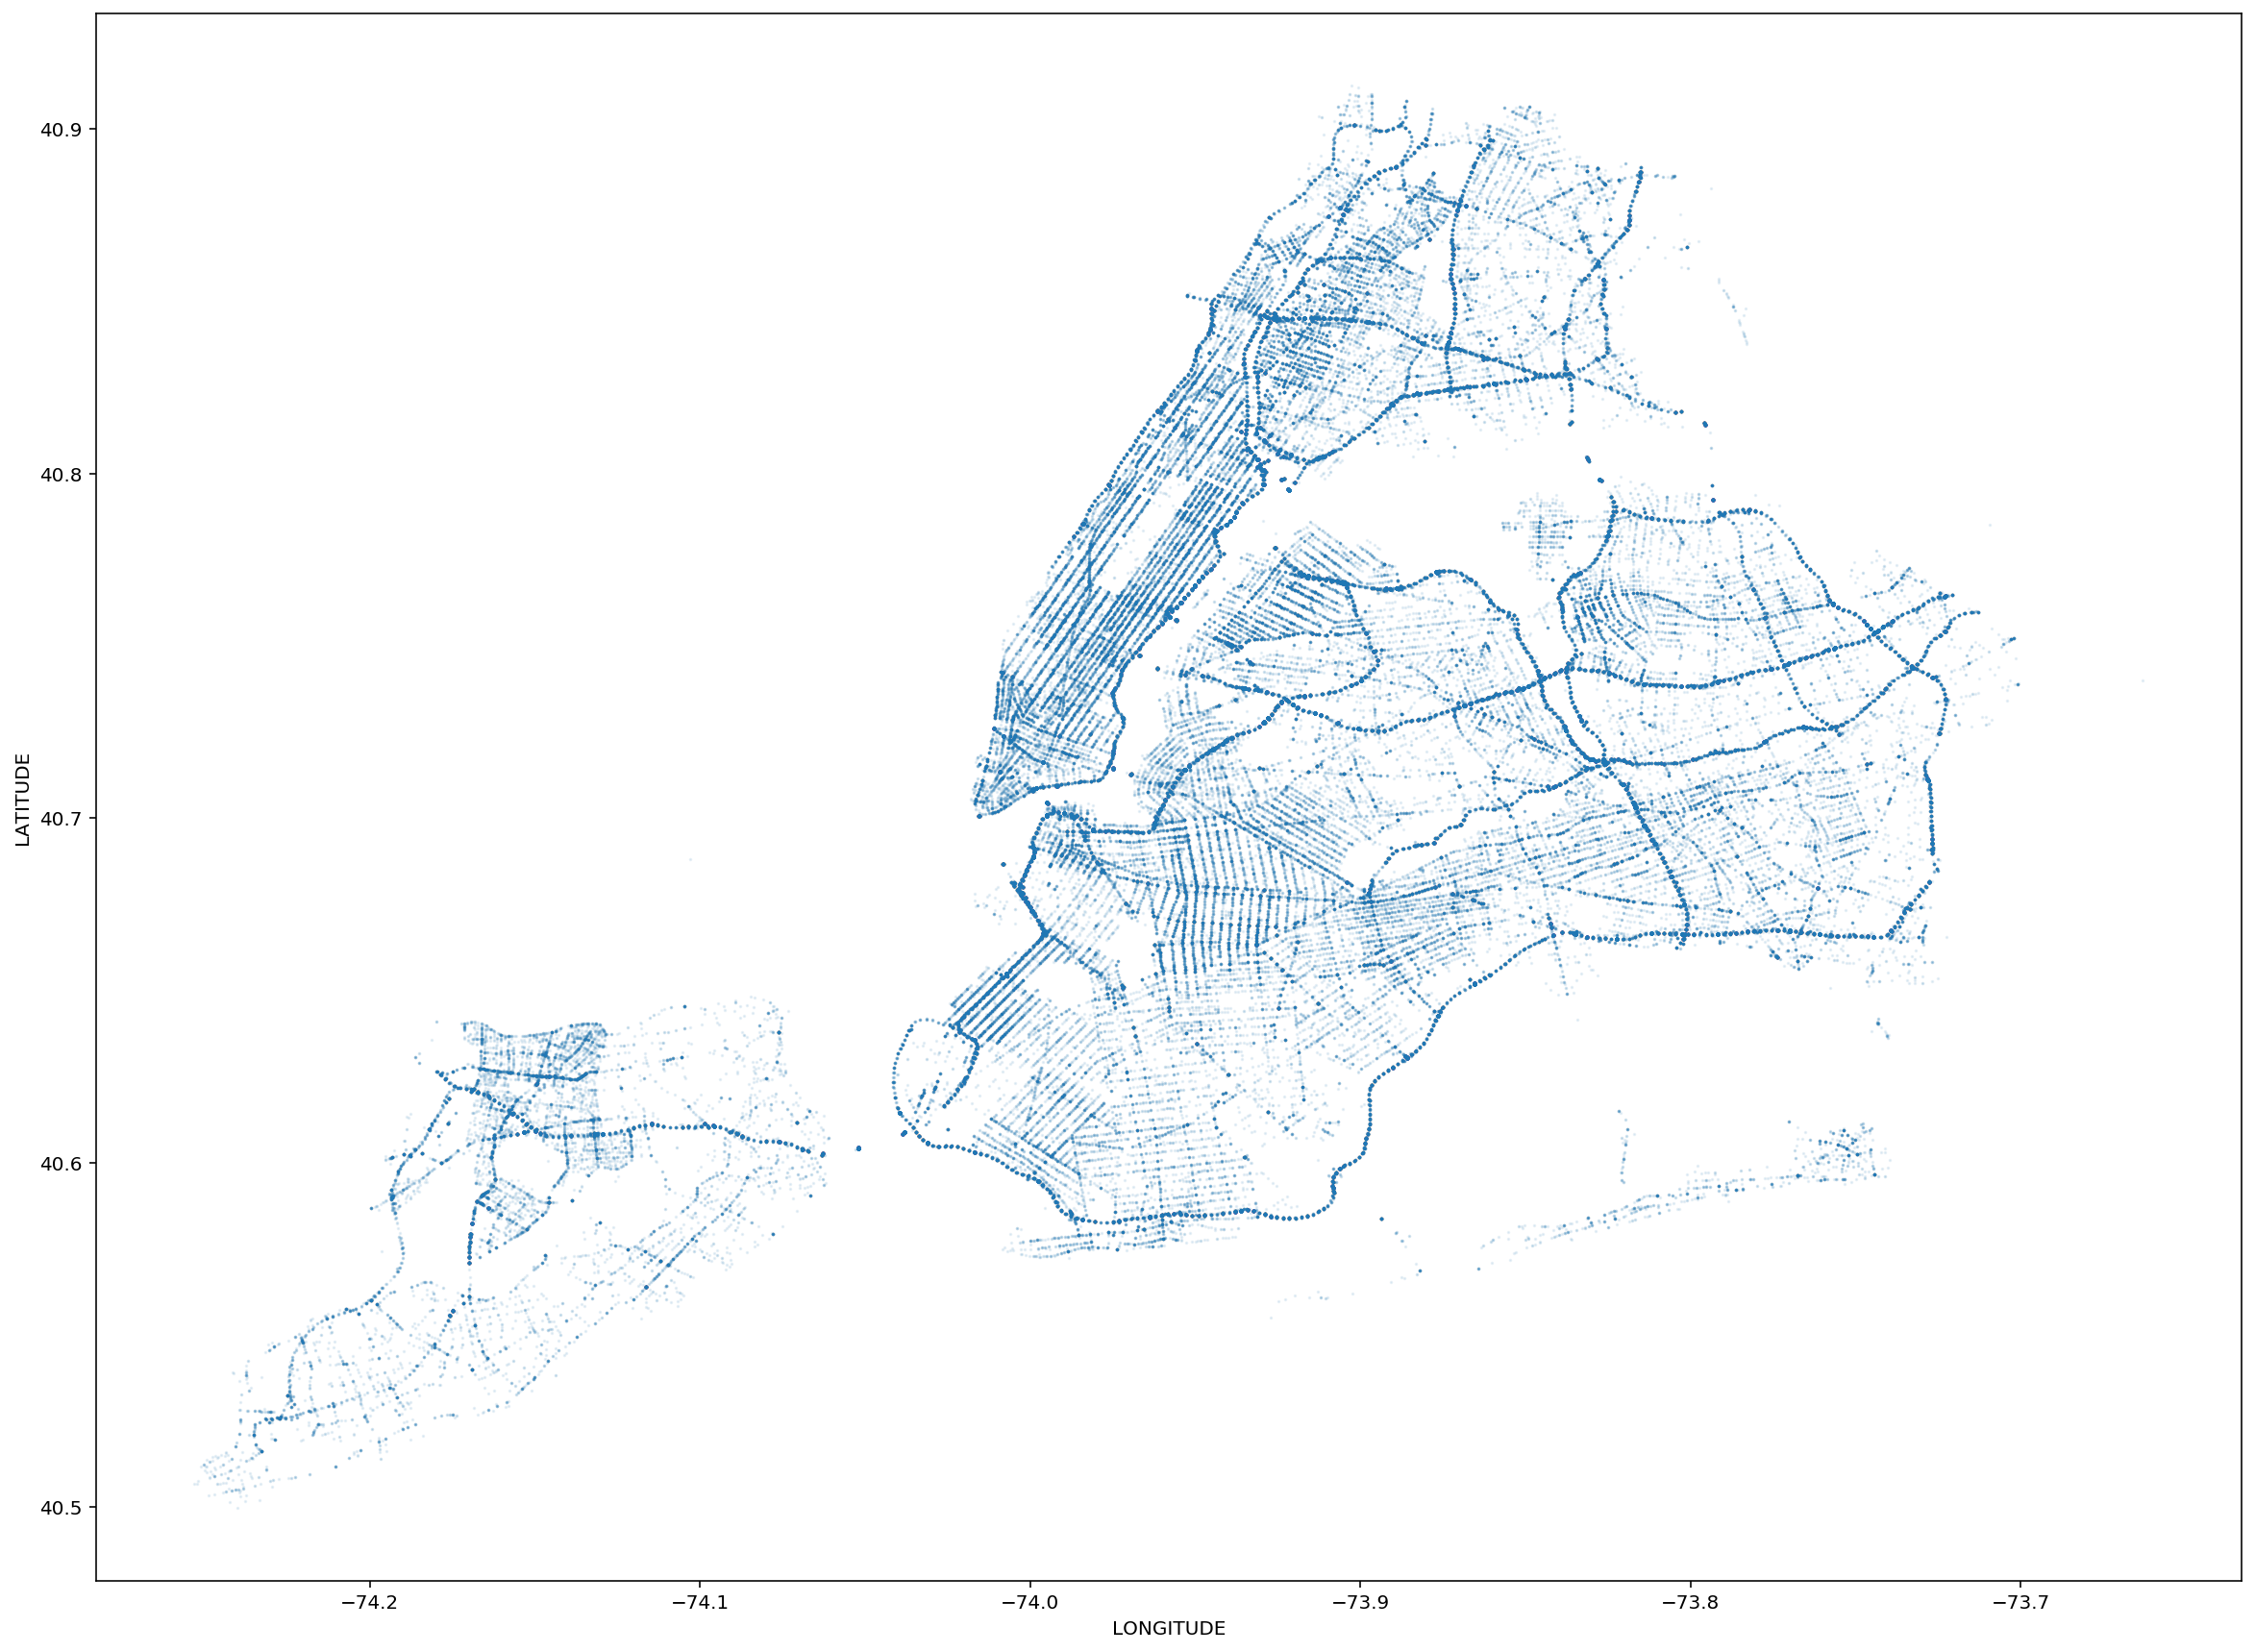

In [55]:
# A map of all the accidents where the BOROUGH is NULL
# We do not detect any obvious spatial patterns of missingness
# at least visually


df[ df.BOROUGH.isnull() & mask ].plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(20, 15),
    s=0.5,
    alpha=0.1)

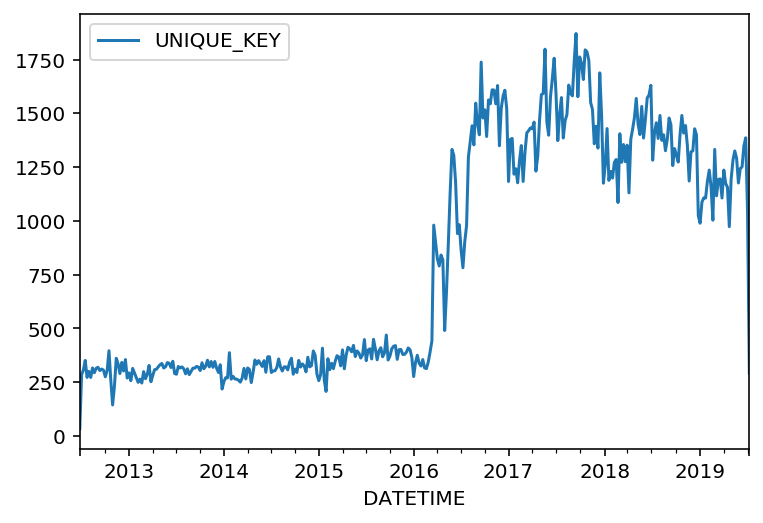

In [56]:
# Check if there is a temporal pattern in the errors

df[ df.BOROUGH.isnull() & mask ].pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

## Augment Borough and Zipcode using Shapefiles

In [57]:
%%time
# We start by converting the LON/LAT attributes into Shapely "geo-points"
# and convert the resut into a geodataframe so that we can do a spatial join 
#from shapely.geometry import Point
#df['Coordinates'] = list(zip(df.LONGITUDE, df.LATITUDE))
#df['Coordinates'] = df['Coordinates'].apply(Point)
#gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))

CPU times: user 13.4 s, sys: 371 ms, total: 13.8 s
Wall time: 13.8 s


In [58]:
len(df)

1523723

In [59]:
# We will now perform a spatial join with the NYC shapefile 
# to find the neighborhood for each accident, and also filter out
# automatically all the accidents that have incorrect coordinates
# and/or incorrect BOROUGH listed

In [60]:
shapefile_url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile'
df_nyc = gpd.GeoDataFrame.from_file(shapefile_url)

In [61]:
df_nyc.crs

{'init': 'epsg:4326'}

In [62]:
%%time
# Match each accident with a neighborhood. 
# Takes ~ 6-7 mins to run
# This is done with left join, 
# so we preserve all the data points
# but we know which ones are not matching with the shapefile
gdf.crs = df_nyc.crs
gdf = gpd.sjoin(gdf, df_nyc, how='left')


CPU times: user 6min 9s, sys: 1.83 s, total: 6min 11s
Wall time: 6min 11s


In [63]:
len(gdf)

1523723

In [64]:
gdf.columns

Index(['UNIQUE_KEY', 'DATETIME', 'BOROUGH', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME',
       'PERSONS_INJURED', 'PERSONS_KILLED', 'PEDESTRIANS_INJURED',
       'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED', 'CYCLISTS_KILLED',
       'MOTORISTS_INJURED', 'MOTORISTS_KILLED', 'Coordinates', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng'],
      dtype='object')

In [65]:
# We keep only boro_name and ntaname
todrop = [
    'index_right', 'boro_code', 'county_fip', 'ntacode',
    'shape_area', 'shape_leng'
]

gdf = gdf.drop(todrop, axis='columns')

# Rename the columns
gdf = gdf.rename({
    'boro_name': 'GEO_BOROUGH',
    'ntaname': 'GEO_NEIGHBORHOOD',
},
                 axis='columns')

In [66]:
gdf.columns.values

array(['UNIQUE_KEY', 'DATETIME', 'BOROUGH', 'ZIPCODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME',
       'OFF_STREET_NAME', 'PERSONS_INJURED', 'PERSONS_KILLED',
       'PEDESTRIANS_INJURED', 'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED',
       'CYCLISTS_KILLED', 'MOTORISTS_INJURED', 'MOTORISTS_KILLED',
       'Coordinates', 'GEO_BOROUGH', 'GEO_NEIGHBORHOOD'], dtype=object)

In [67]:
%%time
shapefile_zip = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
df_zip = gpd.GeoDataFrame.from_file(shapefile_zip)
# Converting the df_zip from {'init': 'epsg:2263'} coordinate system
# to the same lon/lat system used by df_nyc
df_zip = df_zip.to_crs(df_nyc.crs)

# Creating the geodataframe using lon/lat coordinates
# gdf['Coordinates'] = list(zip(gdf.LONGITUDE, gdf.LATITUDE))
# gdf['Coordinates'] = gdf['Coordinates'].apply(Point)
# gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates')

# Spatial inner join, keeping 
gdf.crs = df_zip.crs
gdf = gpd.sjoin(gdf, df_zip, how='left')

todrop = [
    'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS',
    'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'index_right'
]
gdf = gdf.drop(todrop, axis='columns')
gdf = gdf.rename({'ZIPCODE_left': 'ZIPCODE', 'ZIPCODE_right': 'GEO_ZIPCODE'}, axis='columns')

CPU times: user 2min 9s, sys: 1.99 s, total: 2min 11s
Wall time: 2min 12s


In [68]:
gdf.columns.values

array(['UNIQUE_KEY', 'DATETIME', 'BOROUGH', 'ZIPCODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME',
       'OFF_STREET_NAME', 'PERSONS_INJURED', 'PERSONS_KILLED',
       'PEDESTRIANS_INJURED', 'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED',
       'CYCLISTS_KILLED', 'MOTORISTS_INJURED', 'MOTORISTS_KILLED',
       'Coordinates', 'GEO_BOROUGH', 'GEO_NEIGHBORHOOD', 'GEO_ZIPCODE'],
      dtype=object)

In [69]:
len(gdf)

1524587

## Post-Augmentation Analysis of Inconsistencies

In [70]:
len(gdf)

1524587

In [71]:
# Ensure that all collisions are in place
not_matching = set(df['UNIQUE_KEY'].values) - set(gdf['UNIQUE_KEY'].values)
assert( len(not_matching) ==0 )

In [72]:
# Did not match with a shape within the NYC Neighborhoods
len(gdf[ gdf.GEO_BOROUGH.isnull() ])

198224

In [73]:
# Did not match with a shape within the NYC ZIP codes
len(gdf[ gdf.GEO_ZIPCODE.isnull() ])

198955

In [74]:
# Did not match with neither zip nor neighborhood
len(gdf[ gdf.GEO_ZIPCODE.isnull() & gdf.GEO_BOROUGH.isnull() ])

197676

In [75]:
len(gdf[ gdf.GEO_ZIPCODE.isnull() & ~gdf.GEO_BOROUGH.isnull() ])

1279

In [76]:
len(gdf[ ~gdf.GEO_ZIPCODE.isnull() & gdf.GEO_BOROUGH.isnull() ])

548

### Outside general NYC area

These are mainly the entries with no lon/lat, or very incorrect lon/lat

In [77]:
# Defines  LON/LAT entries that are plausibly within NYC
mask = (gdf.LATITUDE > 40) & (gdf.LATITUDE < 41) & (gdf.LONGITUDE < -72) & (gdf.LONGITUDE > -74.5)


In [78]:
# These are the entries that we could filter out with a simple mask
nm1 = gdf[ gdf.GEO_BOROUGH.isnull() & ~mask ]
nm1.head()

UNIQUE_KEY            DATETIME        BOROUGH ZIPCODE  LATITUDE  LONGITUDE  \
6     4167828 2019-07-09 00:00:00  STATEN ISLAND   10309       0.0        0.0   
10    4167407 2019-07-09 00:00:00            NaN     NaN       0.0        0.0   
26    4167458 2019-07-09 10:00:00          BRONX   10461       0.0        0.0   
29    4166906 2019-07-09 10:00:00         QUEENS   11354       0.0        0.0   
38    4168329 2019-07-09 10:05:00            NaN     NaN       0.0        0.0   

      LOCATION                    ON_STREET_NAME   CROSS_STREET_NAME  \
6   (0.0, 0.0)                               NaN                 NaN   
10  (0.0, 0.0)  HENRY HUDSON PARKWAY RAMP                        NaN   
26  (0.0, 0.0)  EASTCHESTER ROAD                      BASSETT AVENUE   
29  (0.0, 0.0)  PRINCE STREET                     NORTHERN BOULEVARD   
38  (0.0, 0.0)  VERRAZANO BRIDGE LOWER                           NaN   

                             OFF_STREET_NAME  ...  PEDESTRIANS_INJURED  \
6   2935      VETERANS ROAD WEST              ...                    0   
10                                       NaN  ...                    0   
26                                       NaN  ...                    0   
29                                       NaN  ...                    0   
38                                       NaN  ...                    0   

    PEDESTRIANS_KILLED  CYCLISTS_INJURED  CYCLISTS_KILLED  MOTORISTS_INJURED  \
6                    0                 0                0                  0   
10                   0                 0                0                  0   
26                   0                 0                0                  0   
29                   0                 0                0                  0   
38                   0                 0                0                  0   

    MOTORISTS_KILLED  Coordinates  GEO_BOROUGH GEO_NEIGHBORHOOD GEO_ZIPCODE  
6                  0  POINT (0 0)          NaN              NaN         NaN  
10                 0  POINT (0 0)          NaN              NaN         NaN  
26                 0  POINT (0 0)          NaN              NaN         NaN  
29                 0  POINT (0 0)          NaN              NaN         NaN  
38                 0  POINT (0 0)          NaN              NaN         NaN  

[5 rows x 22 columns]

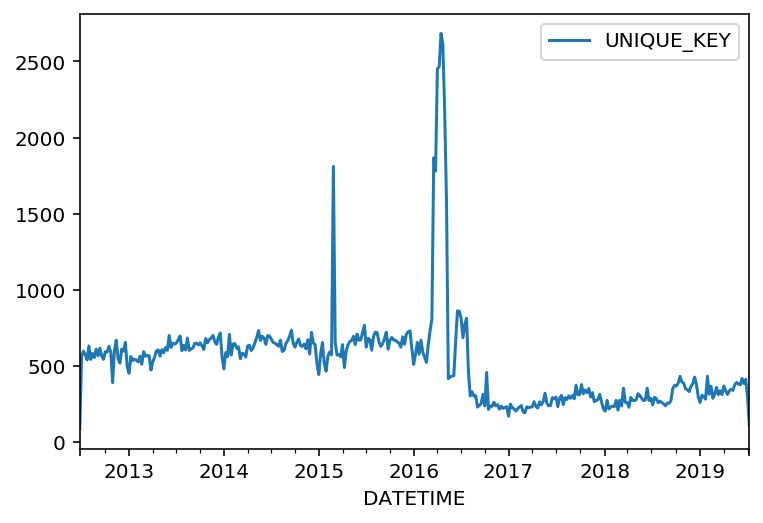

In [79]:
nm1.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [80]:
nm1.LOCATION.value_counts()

(0.0, 0.0)                          190389
(40.75837, -201.23706)                 105
(40.665226000000004, -32.768513)        16
(40.5606, -74.742)                       7
(41.12615, -73.71353)                    5
(40.556175, -47.209625)                  3
(41.061634000000005, -73.97066)          2
(41.258784999999996, -73.99024)          1
(41.34796, -73.96965)                    1
(40.854286, -201.35998999999998)         1
(30.78418, -89.13526999999999)           1
(43.344444, -76.2634)                    1
(42.107203999999996, -76.02163)          1
(42.318317, -73.755936)                  1
(41.12421, -73.71412)                    1
(34.783634, -86.76847)                   1
(41.91661, -79.61955)                    1
(42.64154, -79.00183)                    1
Name: LOCATION, dtype: int64

### No borough detected, within NYC boundaries

In [81]:
# These are the entries that are not matching with a neighborhood
# but are within the NYC boundaries.
nm2 = gdf[gdf.GEO_BOROUGH.isnull() & mask  ]
len(nm2)

7686

In [82]:
nm2.LOCATION.value_counts().head(10)

(40.608757000000004, -74.03808599999999)    670
(40.798256, -73.82744)                      462
(40.604153000000004, -74.05198)             440
(40.704421999999994, -73.99491)             381
(40.604313, -74.05208)                      161
(40.758340000000004, -73.95775)             141
(40.714527000000004, -73.97480999999999)    138
(40.727872999999995, -73.9291223)           138
(40.608364, -74.038666)                     131
(40.704388, -73.994576)                     129
Name: LOCATION, dtype: int64

In [83]:
nm2['ON_STREET_NAME'].value_counts().head(10)

VERRAZANO BRIDGE UPPER              859
BRONX WHITESTONE BRIDGE             774
BROOKLYN BRIDGE                     604
VERRAZANO BRIDGE LOWER              355
THROGS NECK BRIDGE                  344
WILLIAMSBURG BRIDGE OUTER ROADWA    315
BROOKLYN BATTERY TUNNEL             311
QUEENS MIDTOWN TUNNEL               310
TRIBOROUGH BRIDGE                   222
CROSS BRONX EXPY                    209
Name: ON_STREET_NAME, dtype: int64

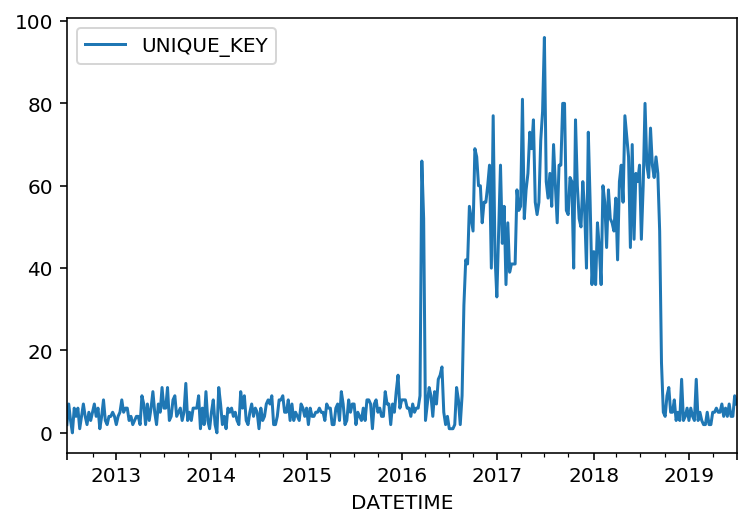

In [84]:
nm2.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

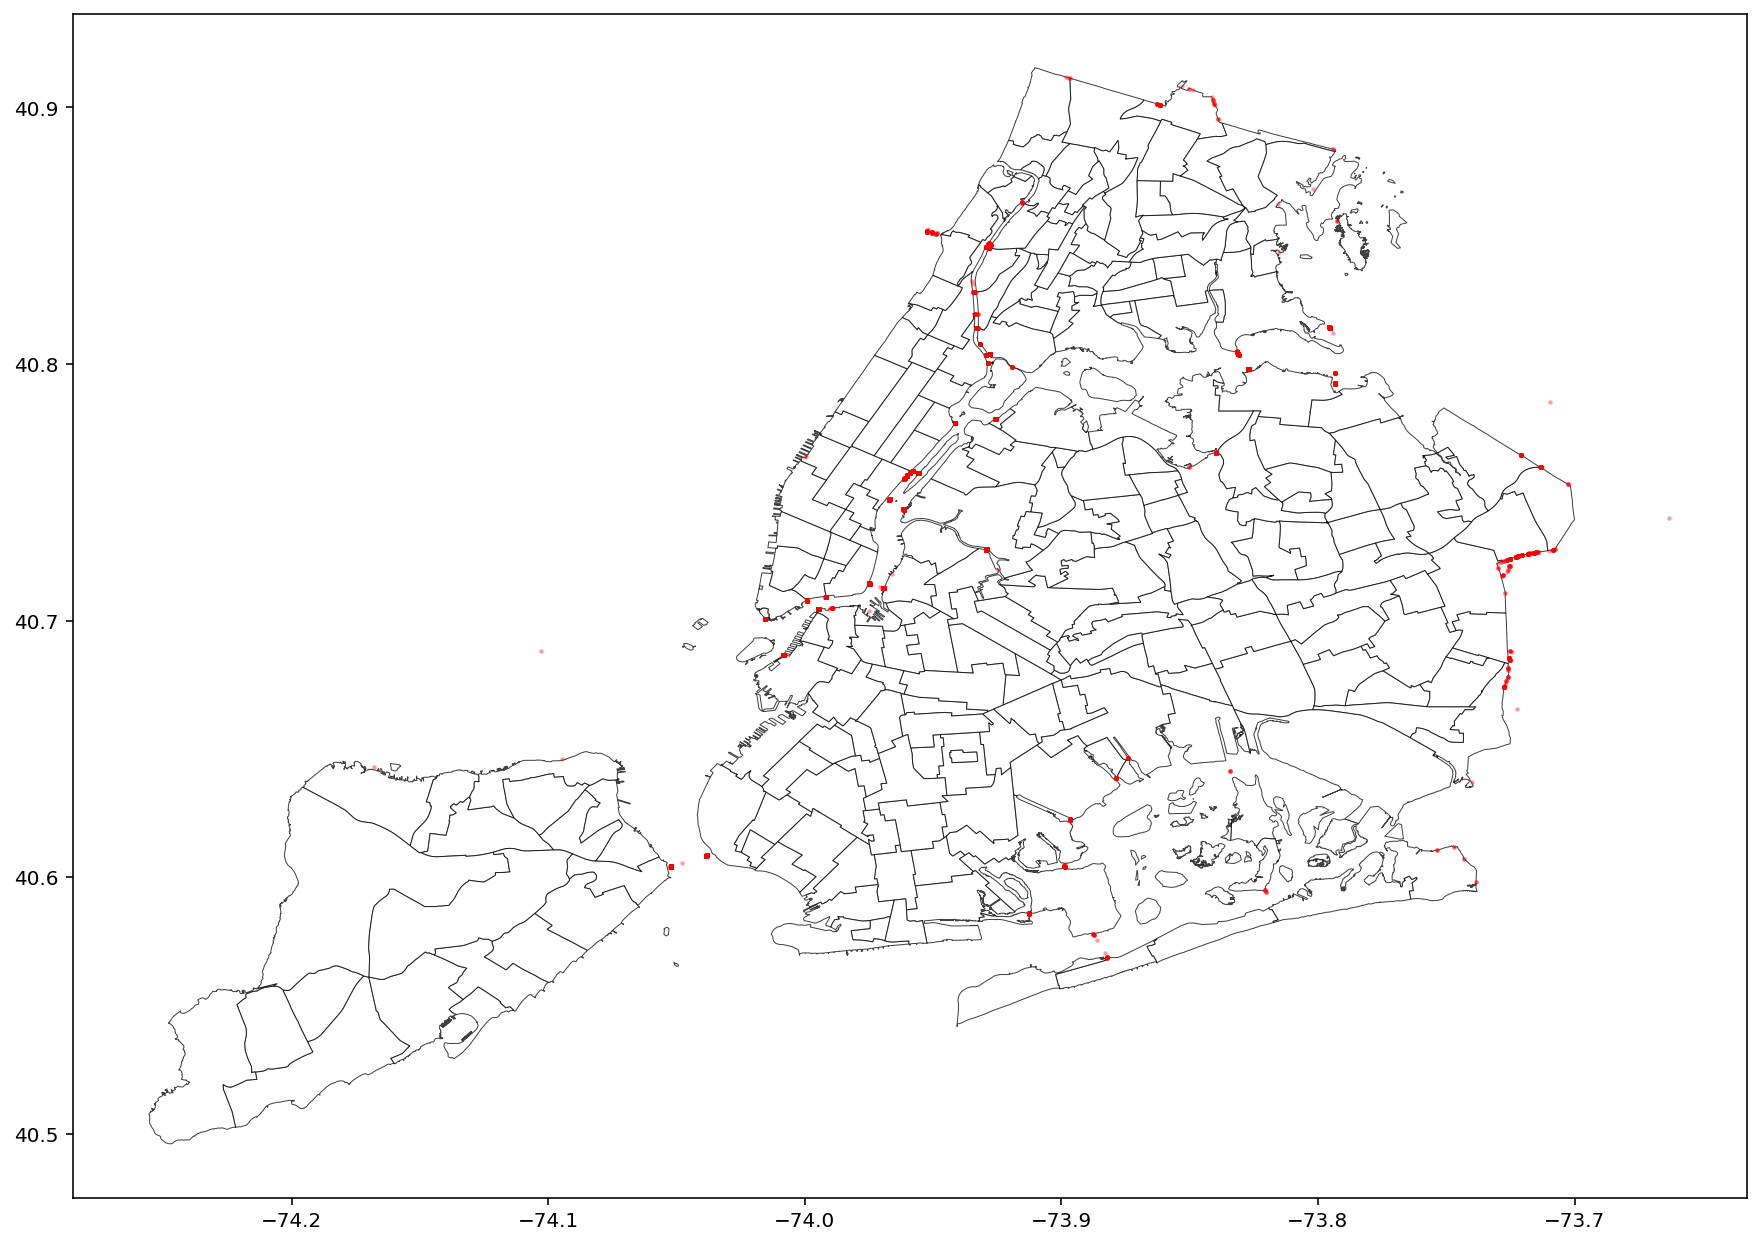

In [85]:
# The plot reveals that these are all bridge accidents
#
# Perhaps we may want to keep them in later versions
#
base = df_nyc.plot(linewidth=0.5,
                   color='White',
                   edgecolor='Black',
                   figsize=(15, 12),
                   alpha=0.75)

nm2.plot(figsize=(15, 12), c='red', markersize=2, alpha=0.25, ax=base)

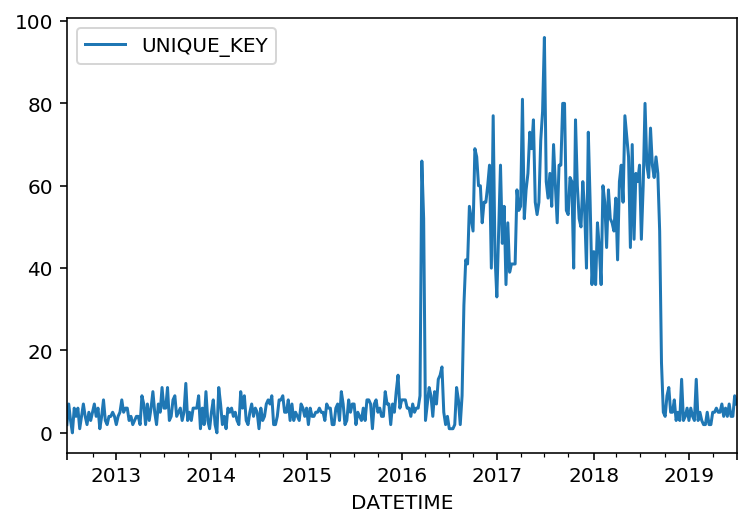

In [86]:
nm2.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

### No ZIP detected, within NYC boundaries

In [87]:
# These are the entries that are not matching with a neighborhood
# but are within the NYC boundaries.
nm3 = gdf[gdf.GEO_ZIPCODE.isnull() & mask  ]
len(nm3)

8417

In [88]:
nm3['ON_STREET_NAME'].value_counts().head(20)

VERRAZANO BRIDGE UPPER              859
BRONX WHITESTONE BRIDGE             774
BROOKLYN BRIDGE                     604
VERRAZANO BRIDGE LOWER              355
THROGS NECK BRIDGE                  344
WILLIAMSBURG BRIDGE OUTER ROADWA    315
BROOKLYN BATTERY TUNNEL             311
QUEENS MIDTOWN TUNNEL               310
ROCKAWAY BOULEVARD                  264
TRIBOROUGH BRIDGE                   222
METROPOLITAN AVENUE                 214
CROSS BRONX EXPY                    209
WILLIAMSBURG BRIDGE INNER ROADWA    191
FDR DRIVE                           191
QUEENSBORO BRIDGE LOWER ROADWAY     186
MANHATTAN BR UPPER                  176
WILLIS AVE BRIDGE                   170
VERRAZANO BRIDGE                    159
BROOKLYN QUEENS EXPRESSWAY          146
QUEENSBORO BRIDGE LOWER             144
Name: ON_STREET_NAME, dtype: int64

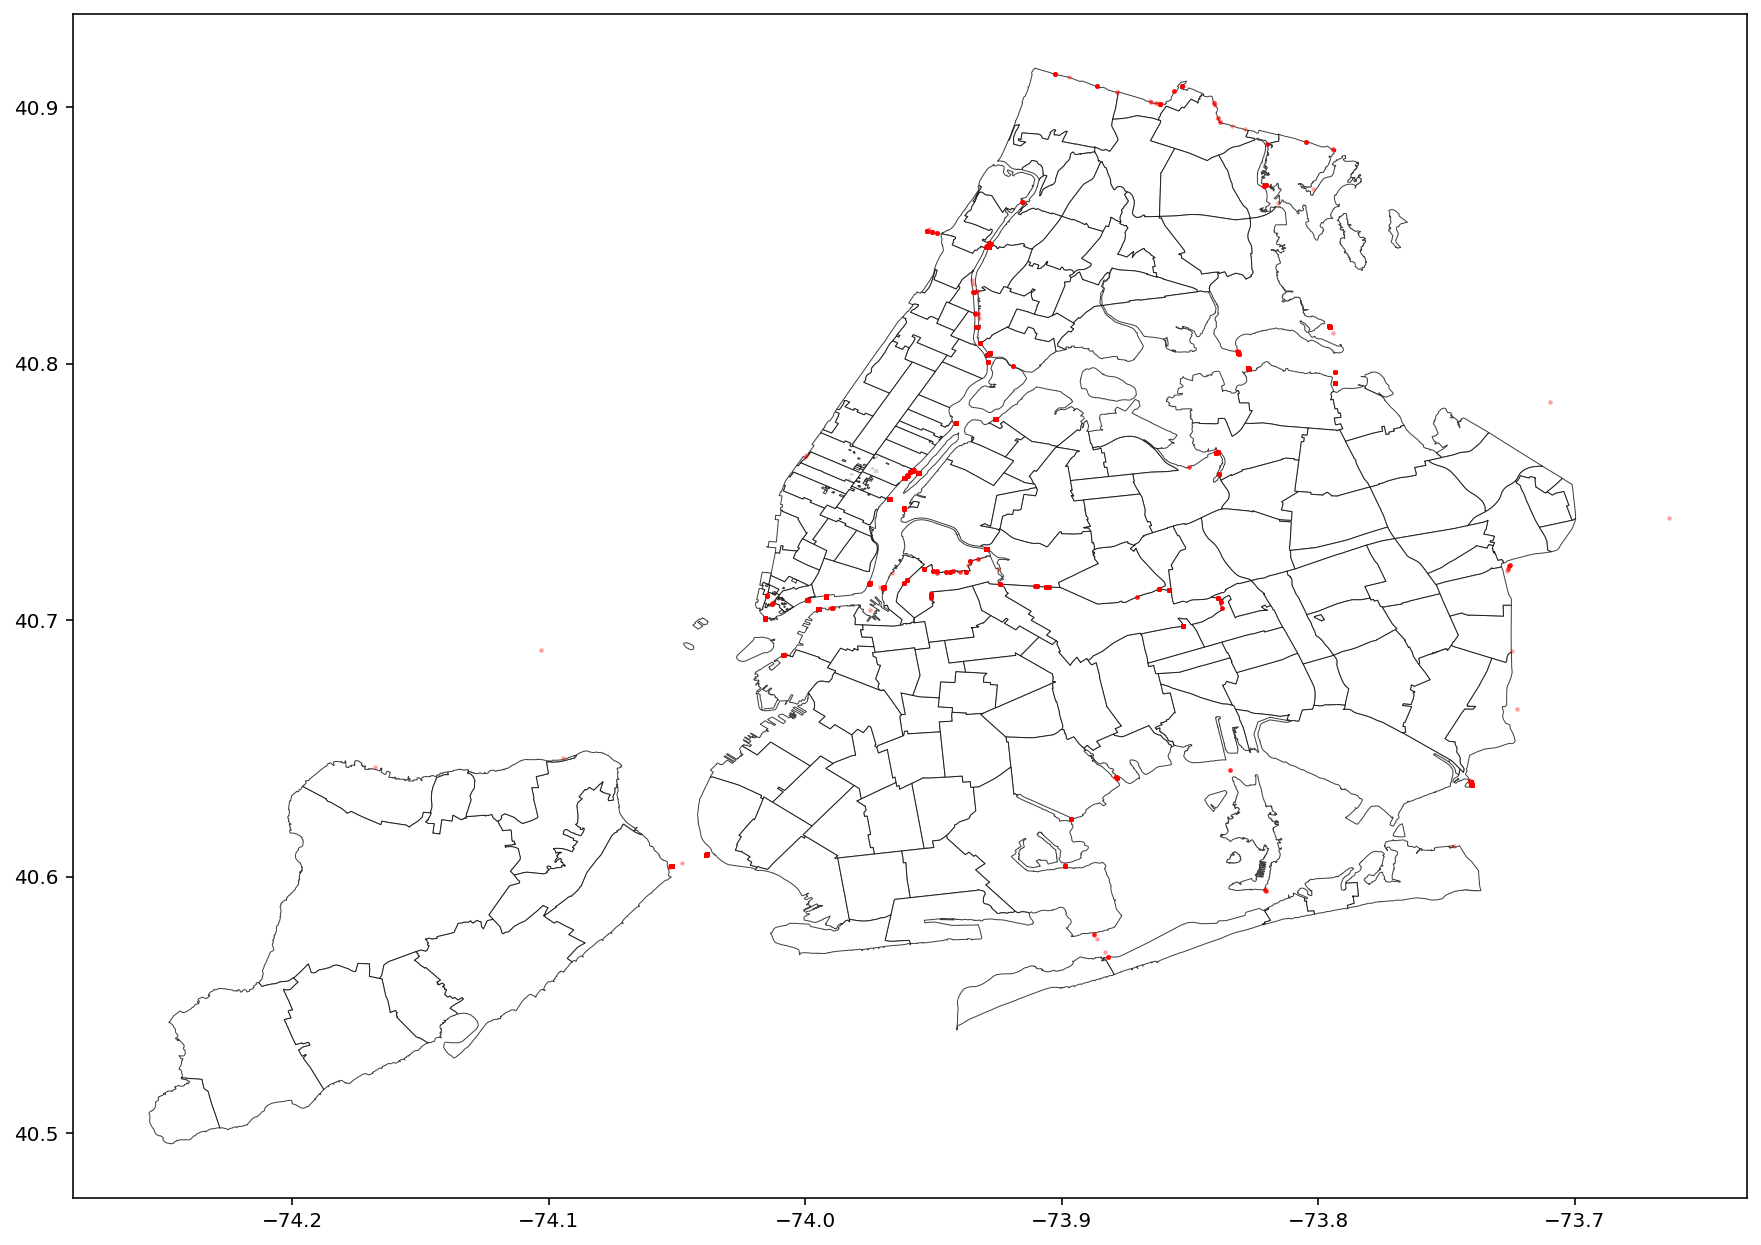

In [89]:
# The plot reveals that these are all bridge accidents
#
# Perhaps we may want to keep them in later versions
#
base = df_zip.plot(linewidth=0.5,
                   color='White',
                   edgecolor='Black',
                   figsize=(15, 12),
                   alpha=0.75)

nm3.plot(figsize=(15, 12), c='red', markersize=2, alpha=0.25, ax=base)

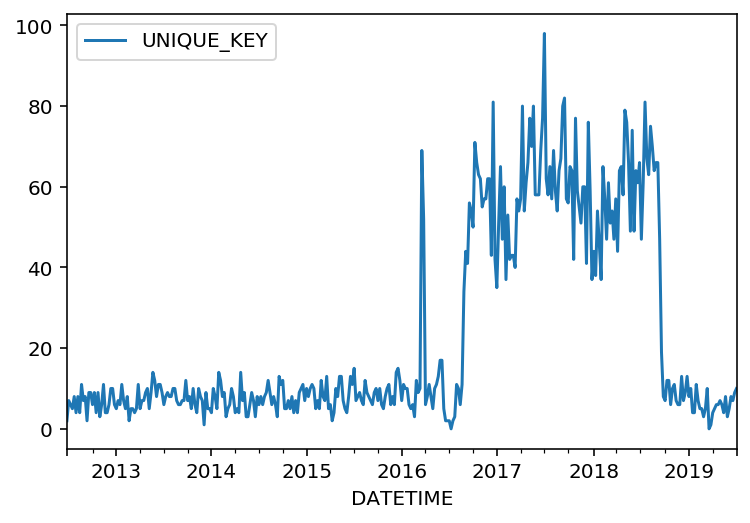

In [90]:
nm3.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

### Discrepancy between detected and reported borough

In [91]:
# Code below lists cases where the borough is incorrectly coded based on lon/lat
# TODO: Perhaps also check cases where zipcode is incorrectly coded
errors_boro = gdf[mask & ~gdf.BOROUGH.isnull() & ~gdf.GEO_BOROUGH.isnull() &
                  (gdf.GEO_BOROUGH.str.lower() != gdf.BOROUGH.str.lower())]
errors_boro = pd.DataFrame(errors_boro)

In [92]:
len(errors_boro)

1767

In [93]:
errors_boro.LOCATION.value_counts().head(10)

(40.7136, -74.0091)                  92
(40.8756831, -73.9083783)            58
(40.7244, -73.9818)                  50
(40.7339, -73.9542)                  45
(40.699937799999994, -73.9118079)    38
(40.873642, -73.90796999999999)      36
(40.8772207, -73.90904509999999)     32
(40.875640000000004, -73.90836)      28
(40.699531, -73.91103670000001)      28
(40.7086946, -73.92070179999999)     18
Name: LOCATION, dtype: int64

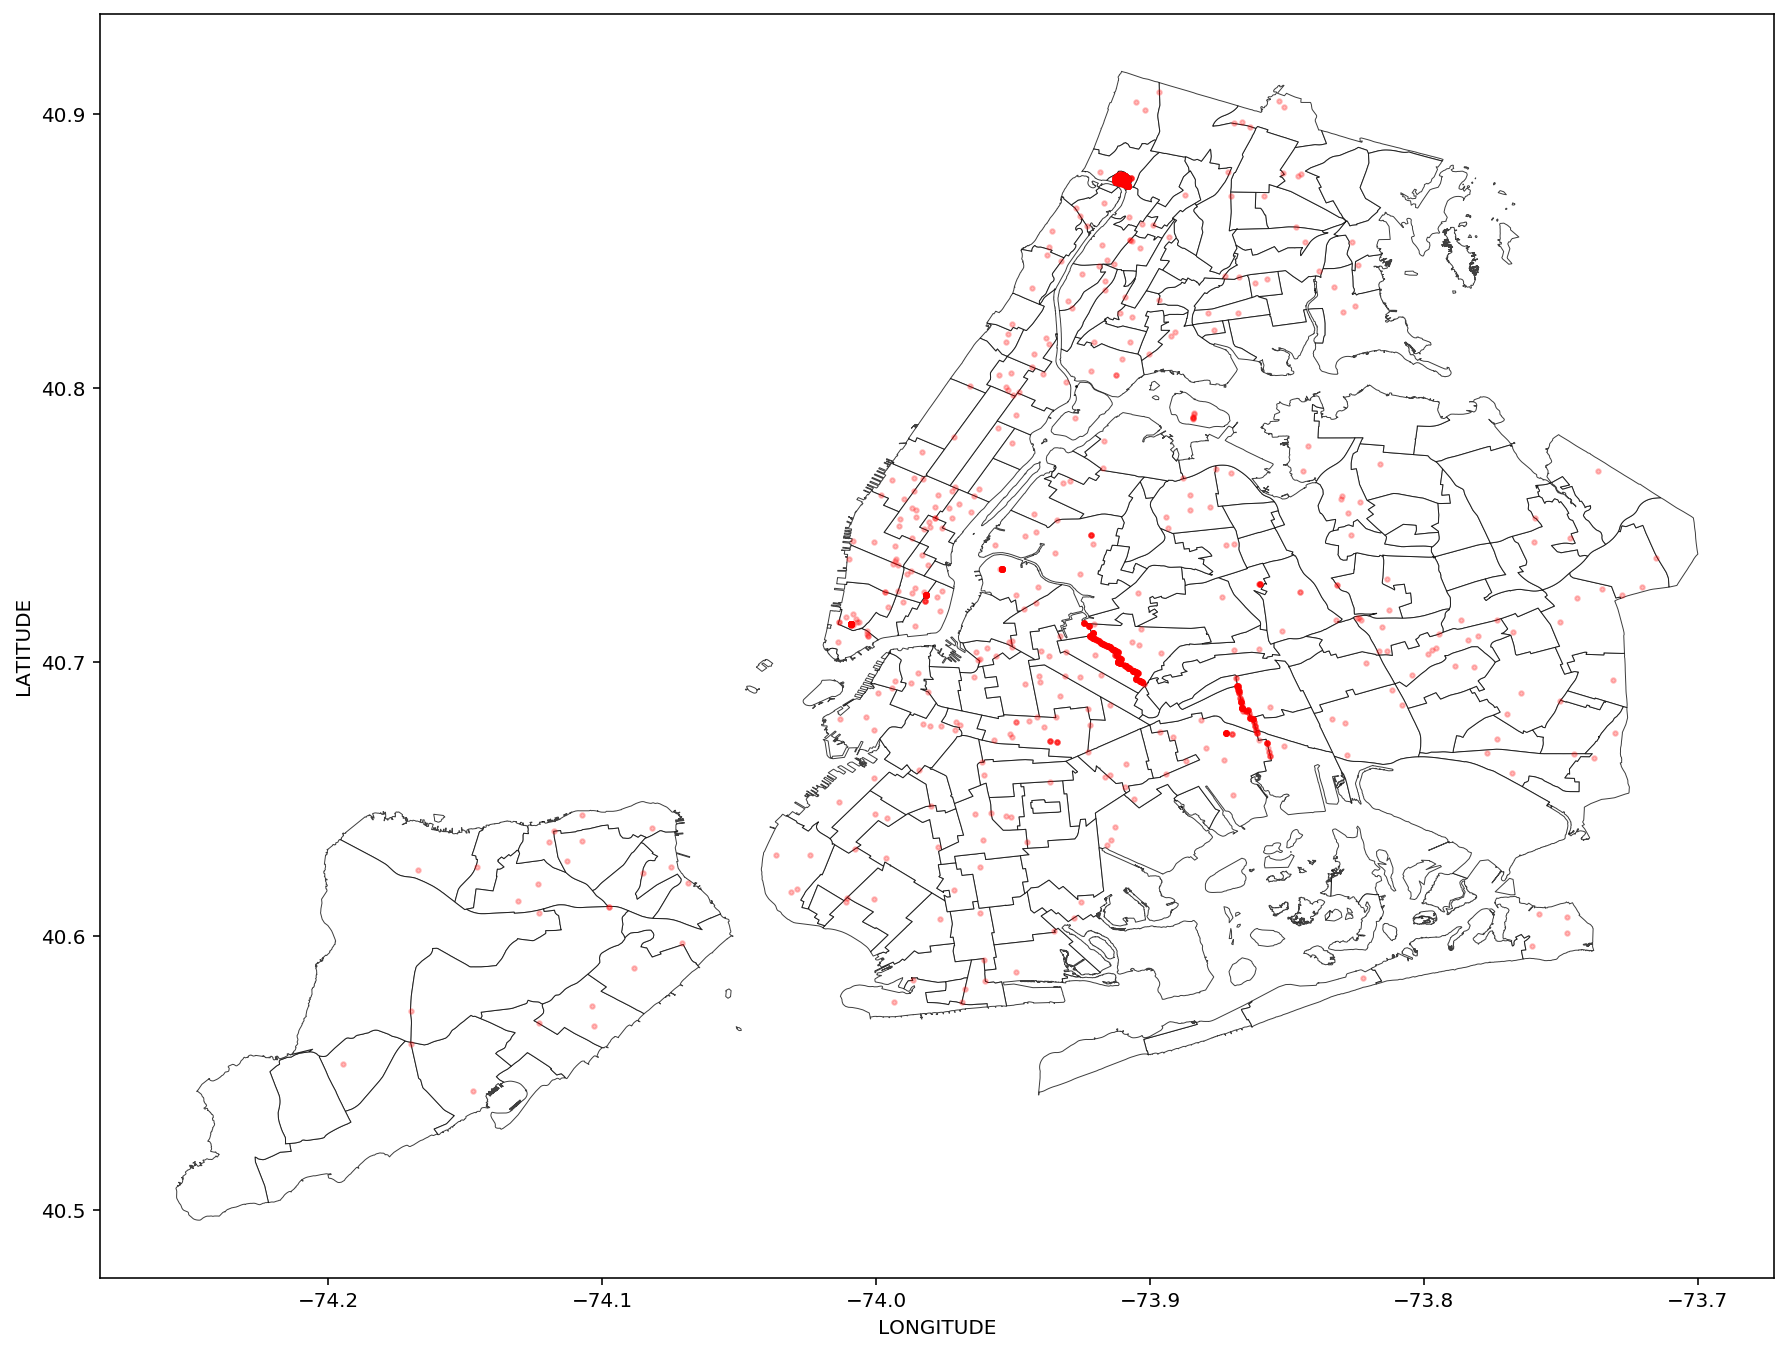

In [94]:
# The plot reveals that most are border issues
# but there are random errors spread throughout the city
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors_boro.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=5,
    alpha=0.25, ax=base)

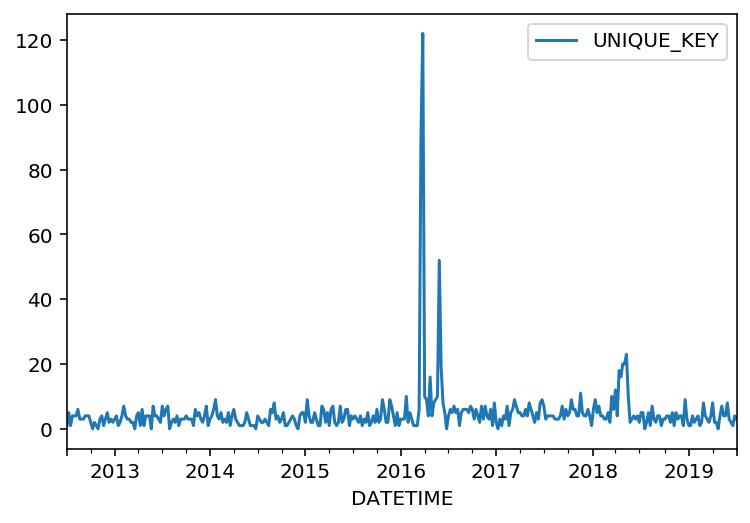

In [95]:
errors_boro.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [96]:
# Check cases where there was a reported borough code but not a detected one
errors_boro2 = gdf [mask & ~gdf.BOROUGH.isnull() & gdf.GEO_BOROUGH.isnull()]
errors_boro2 = pd.DataFrame(errors_boro2)
len(errors_boro2)

459

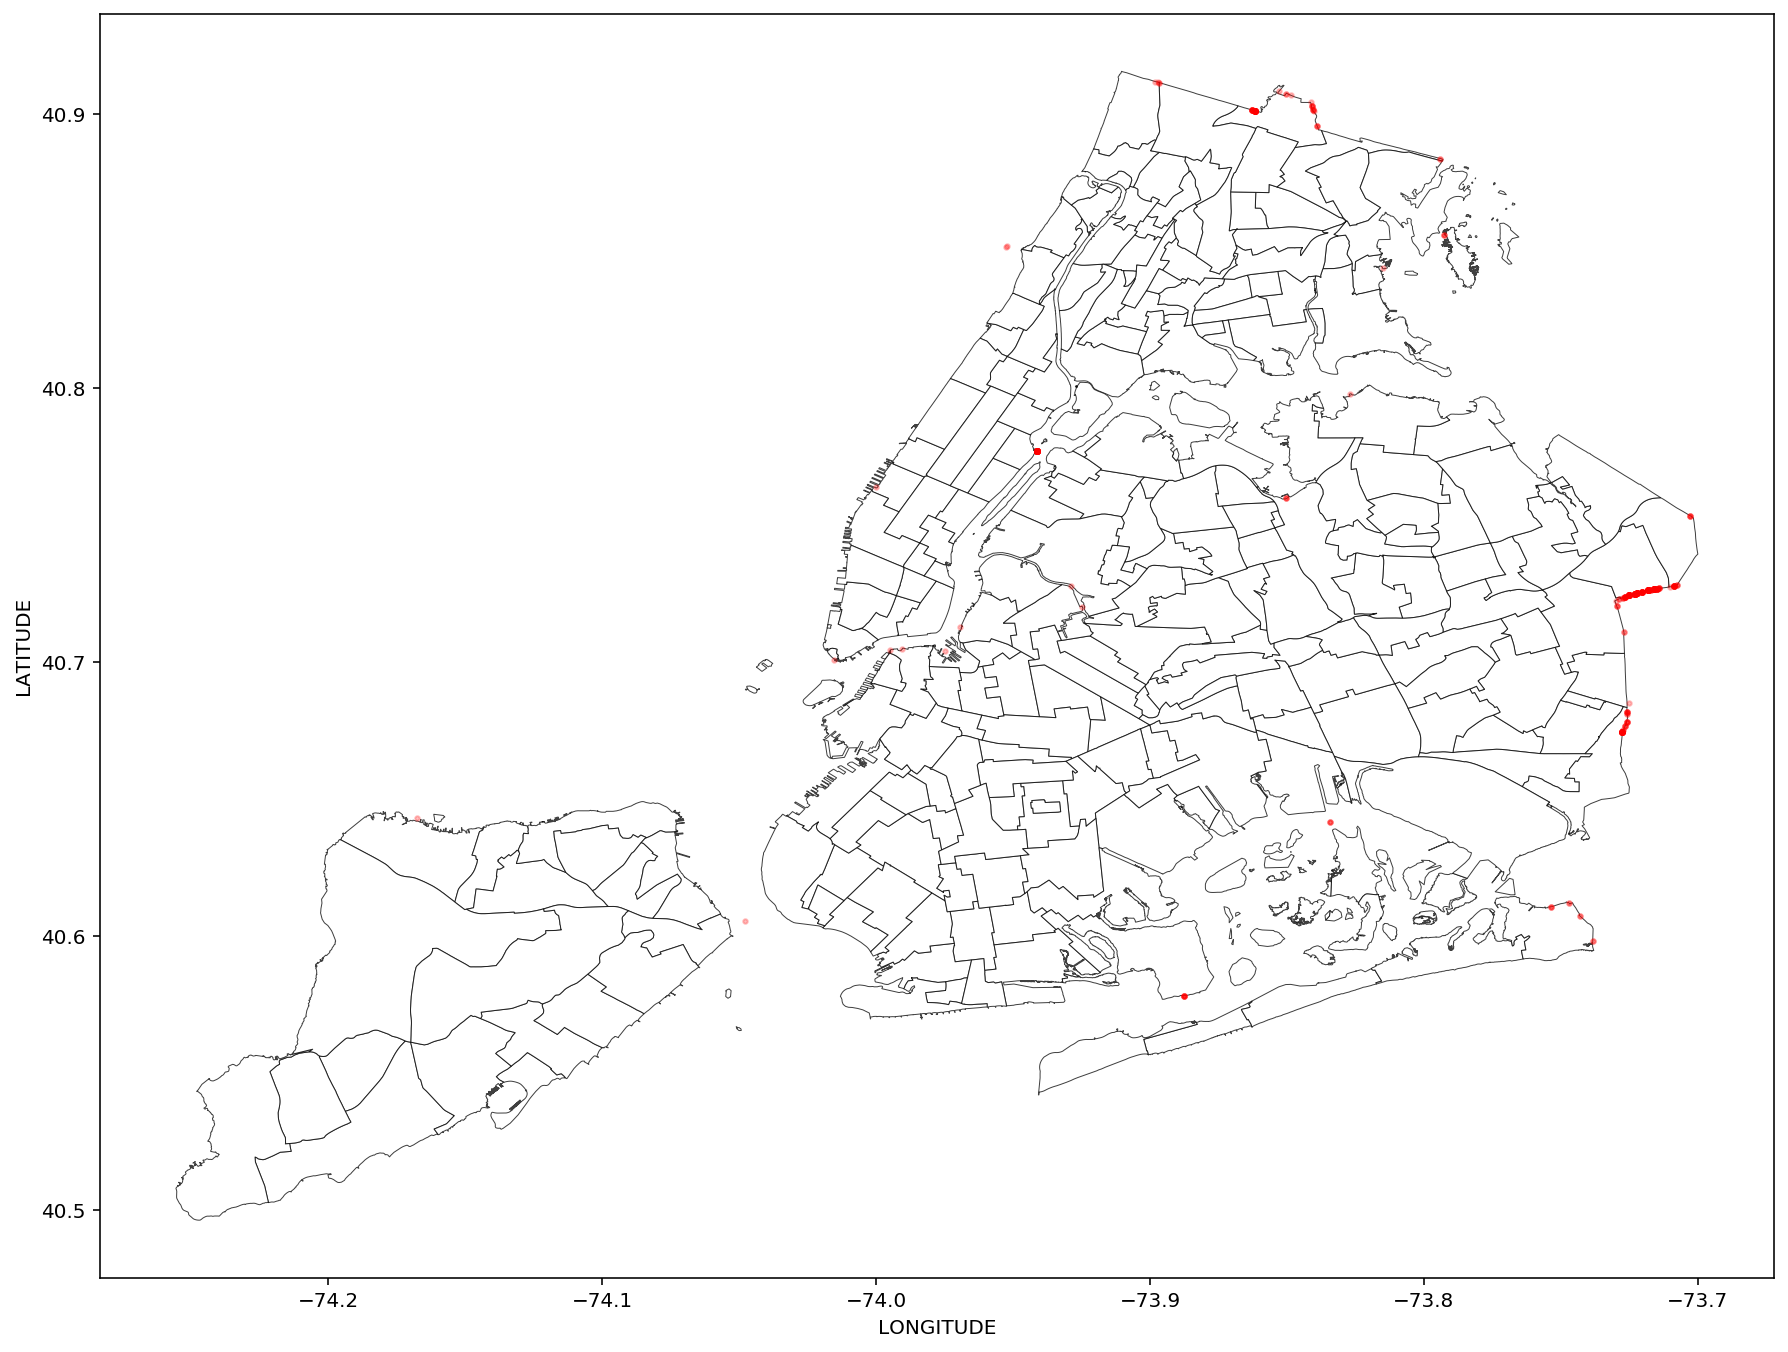

In [97]:
# The plot reveals that most are border issues
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors_boro2.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=5,
    alpha=0.25, ax=base)

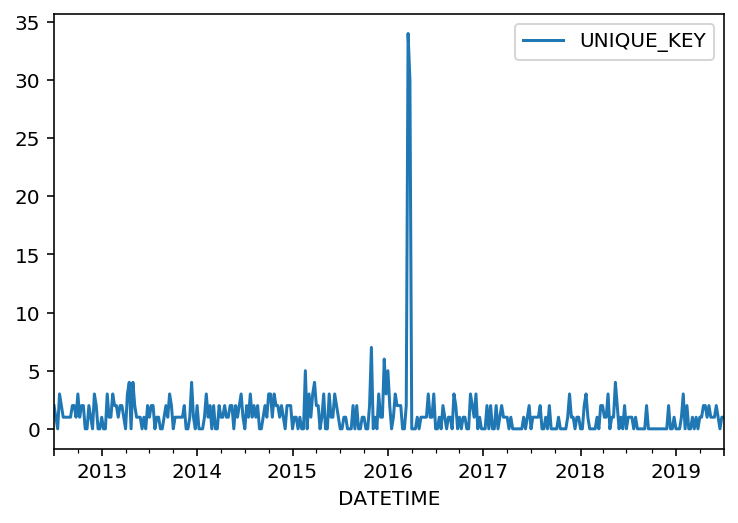

In [98]:
errors_boro2.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

### Discrepancy between detected and reported zip

In [99]:
# Code below lists cases where the borough is incorrectly coded based on lon/lat
errors_zip = gdf [ mask & ~gdf.ZIPCODE.isnull() & ~gdf.GEO_ZIPCODE.isnull() & (gdf.GEO_ZIPCODE != gdf.ZIPCODE) ]
errors_zip = pd.DataFrame(errors_zip)
len(errors_zip)

87930

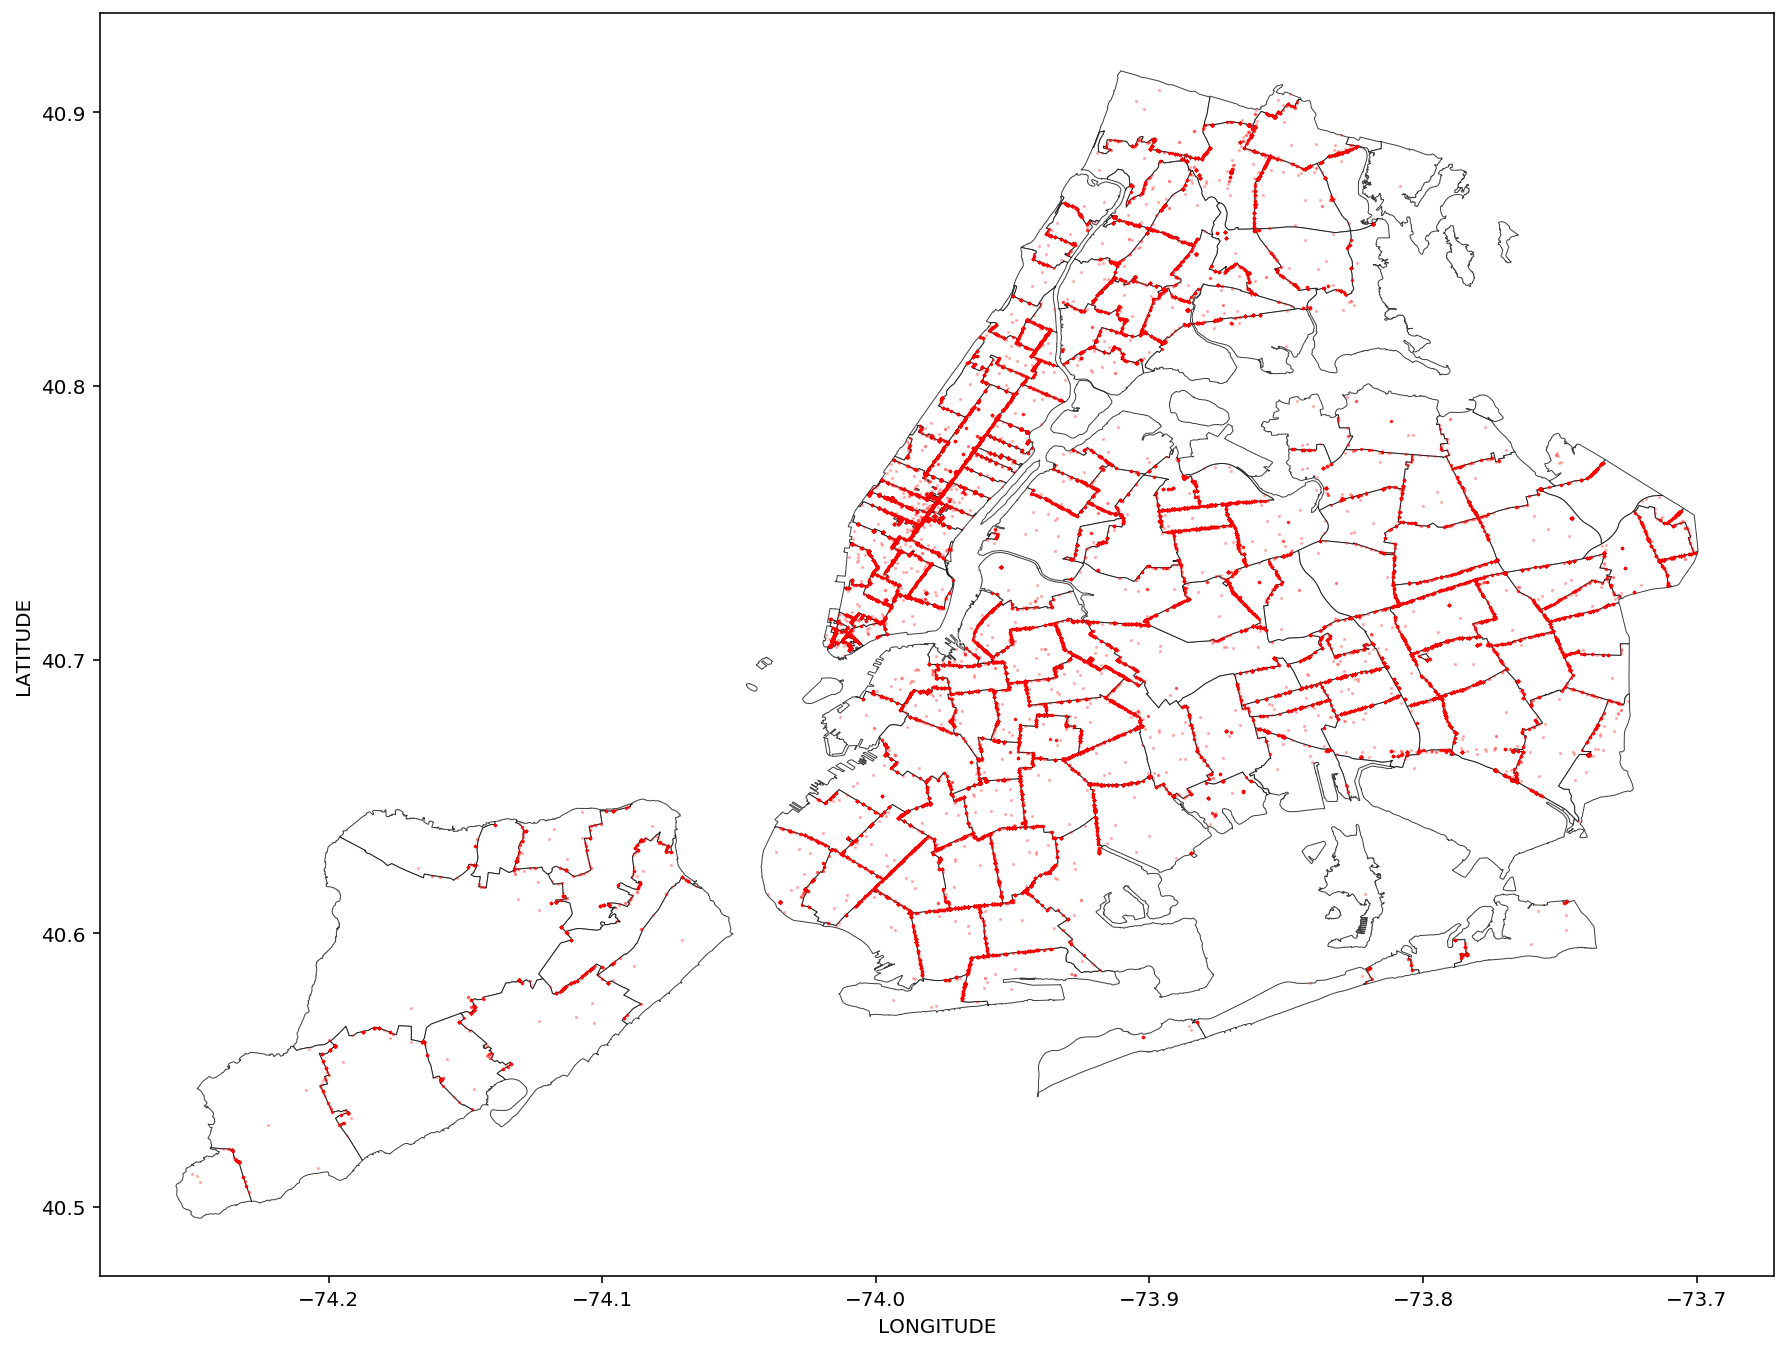

In [100]:
# The plot reveals that most are border issues
# but there are random errors spread throughout the city
base = df_zip.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors_zip.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=0.5,
    alpha=0.25, ax=base)

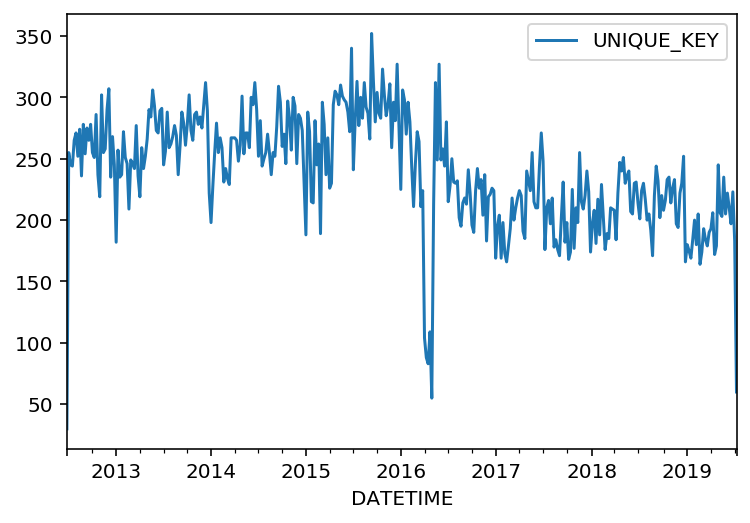

In [101]:
errors_zip.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

In [102]:
# Check cases where there was a reported ZIP code but not a detected one
errors_zip2 = gdf [ mask & ~gdf.ZIPCODE.isnull() & gdf.GEO_ZIPCODE.isnull() ]
errors_zip2 = pd.DataFrame(errors_zip2)
len(errors_zip2)

1173

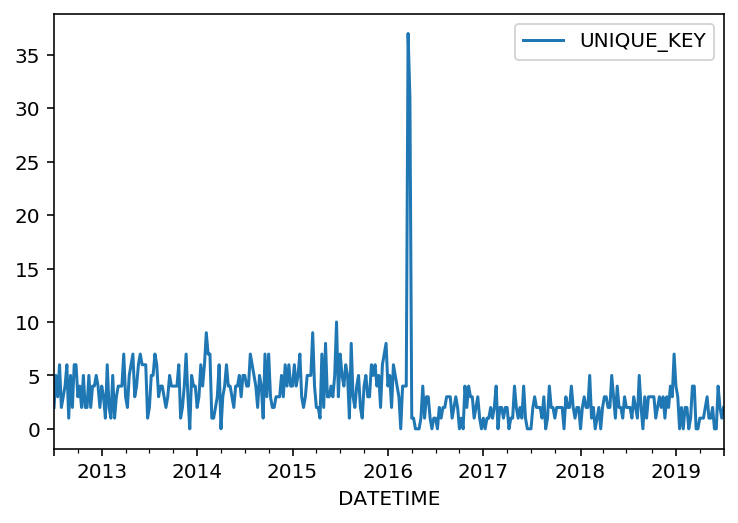

In [103]:
errors_zip2.pivot_table(
    index='DATETIME',
    values='UNIQUE_KEY',
    aggfunc='count'
).resample('1W').sum().plot()

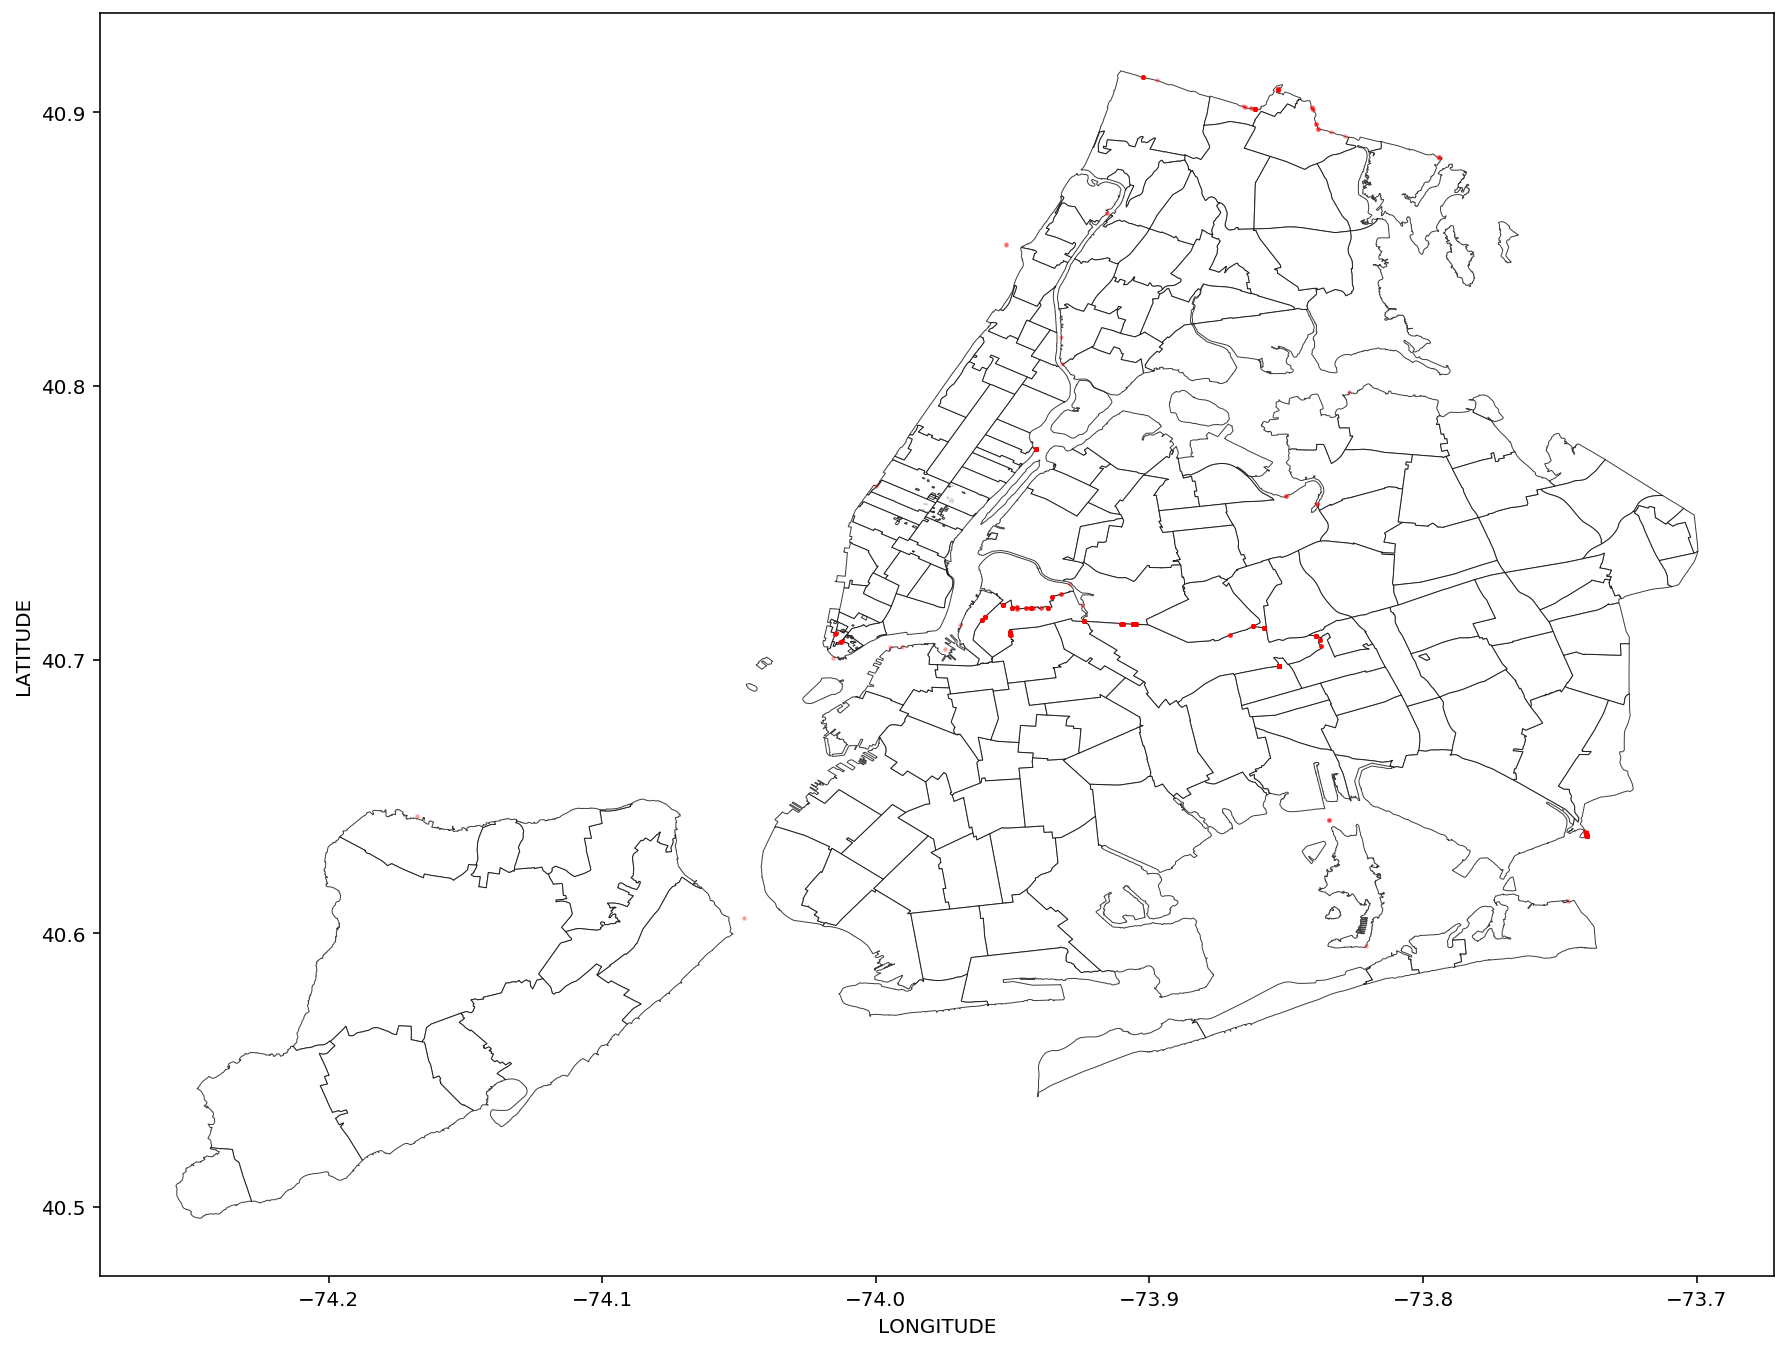

In [104]:
# The plot reveals that most are border issues
base = df_zip.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

errors_zip2.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    figsize=(15, 12),
    c='red',
    s=2,
    alpha=0.25, ax=base)

## Prepare Final DataSet

In [105]:
gdf.columns.values

array(['UNIQUE_KEY', 'DATETIME', 'BOROUGH', 'ZIPCODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME',
       'OFF_STREET_NAME', 'PERSONS_INJURED', 'PERSONS_KILLED',
       'PEDESTRIANS_INJURED', 'PEDESTRIANS_KILLED', 'CYCLISTS_INJURED',
       'CYCLISTS_KILLED', 'MOTORISTS_INJURED', 'MOTORISTS_KILLED',
       'Coordinates', 'GEO_BOROUGH', 'GEO_NEIGHBORHOOD', 'GEO_ZIPCODE'],
      dtype=object)

In [106]:
# Defines LON/LAT entries that are plausibly within NYC
# We will use the mask to set to NULL all other lat/lon values
# The analysis above indicates that the lon/lat that are within the mask
# but "do not match" are actually, fine and most are border cases
mask = (gdf.LATITUDE > 40) & (gdf.LATITUDE < 41) & (gdf.LONGITUDE < -72) & (gdf.LONGITUDE > -74.5)

gdf.loc[~mask, 'LATITUDE'] = None
gdf.loc[~mask, 'LONGITUDE'] = None

In [107]:
# Keeping the ZIP and BOROUGH from the original dataset 
# but changing its names, to distinguish from the detected
# ones from the shapefiles

gdf = gdf.rename(
    {
        'ZIPCODE': 'REPORTED_ZIPCODE',
        'BOROUGH': 'REPORTED_BOROUGH',
    },
    axis='columns')

gdf = gdf.rename(
    {
        'GEO_ZIPCODE': 'ZIPCODE',
        'GEO_BOROUGH': 'BOROUGH',
        'GEO_NEIGHBORHOOD': 'NEIGHBORHOOD'
    },
    axis='columns')

In [108]:
# Reorder the columns, dropping columns we do not need

columns = [
    'UNIQUE_KEY', 'DATETIME', 'LATITUDE', 'LONGITUDE', 
    'ZIPCODE', 'NEIGHBORHOOD', 'BOROUGH', 
    'PERSONS_INJURED', 'PERSONS_KILLED', 
    'PEDESTRIANS_INJURED', 'PEDESTRIANS_KILLED', 
    'CYCLISTS_INJURED', 'CYCLISTS_KILLED',
    'MOTORISTS_INJURED', 'MOTORISTS_KILLED', 
    'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME',
    'REPORTED_ZIPCODE', 'REPORTED_BOROUGH'
]

gdf = gdf[columns]

In [109]:
# Sort by date
gdf = gdf.sort_values('DATETIME')

In [110]:
final_df = pd.DataFrame(gdf)

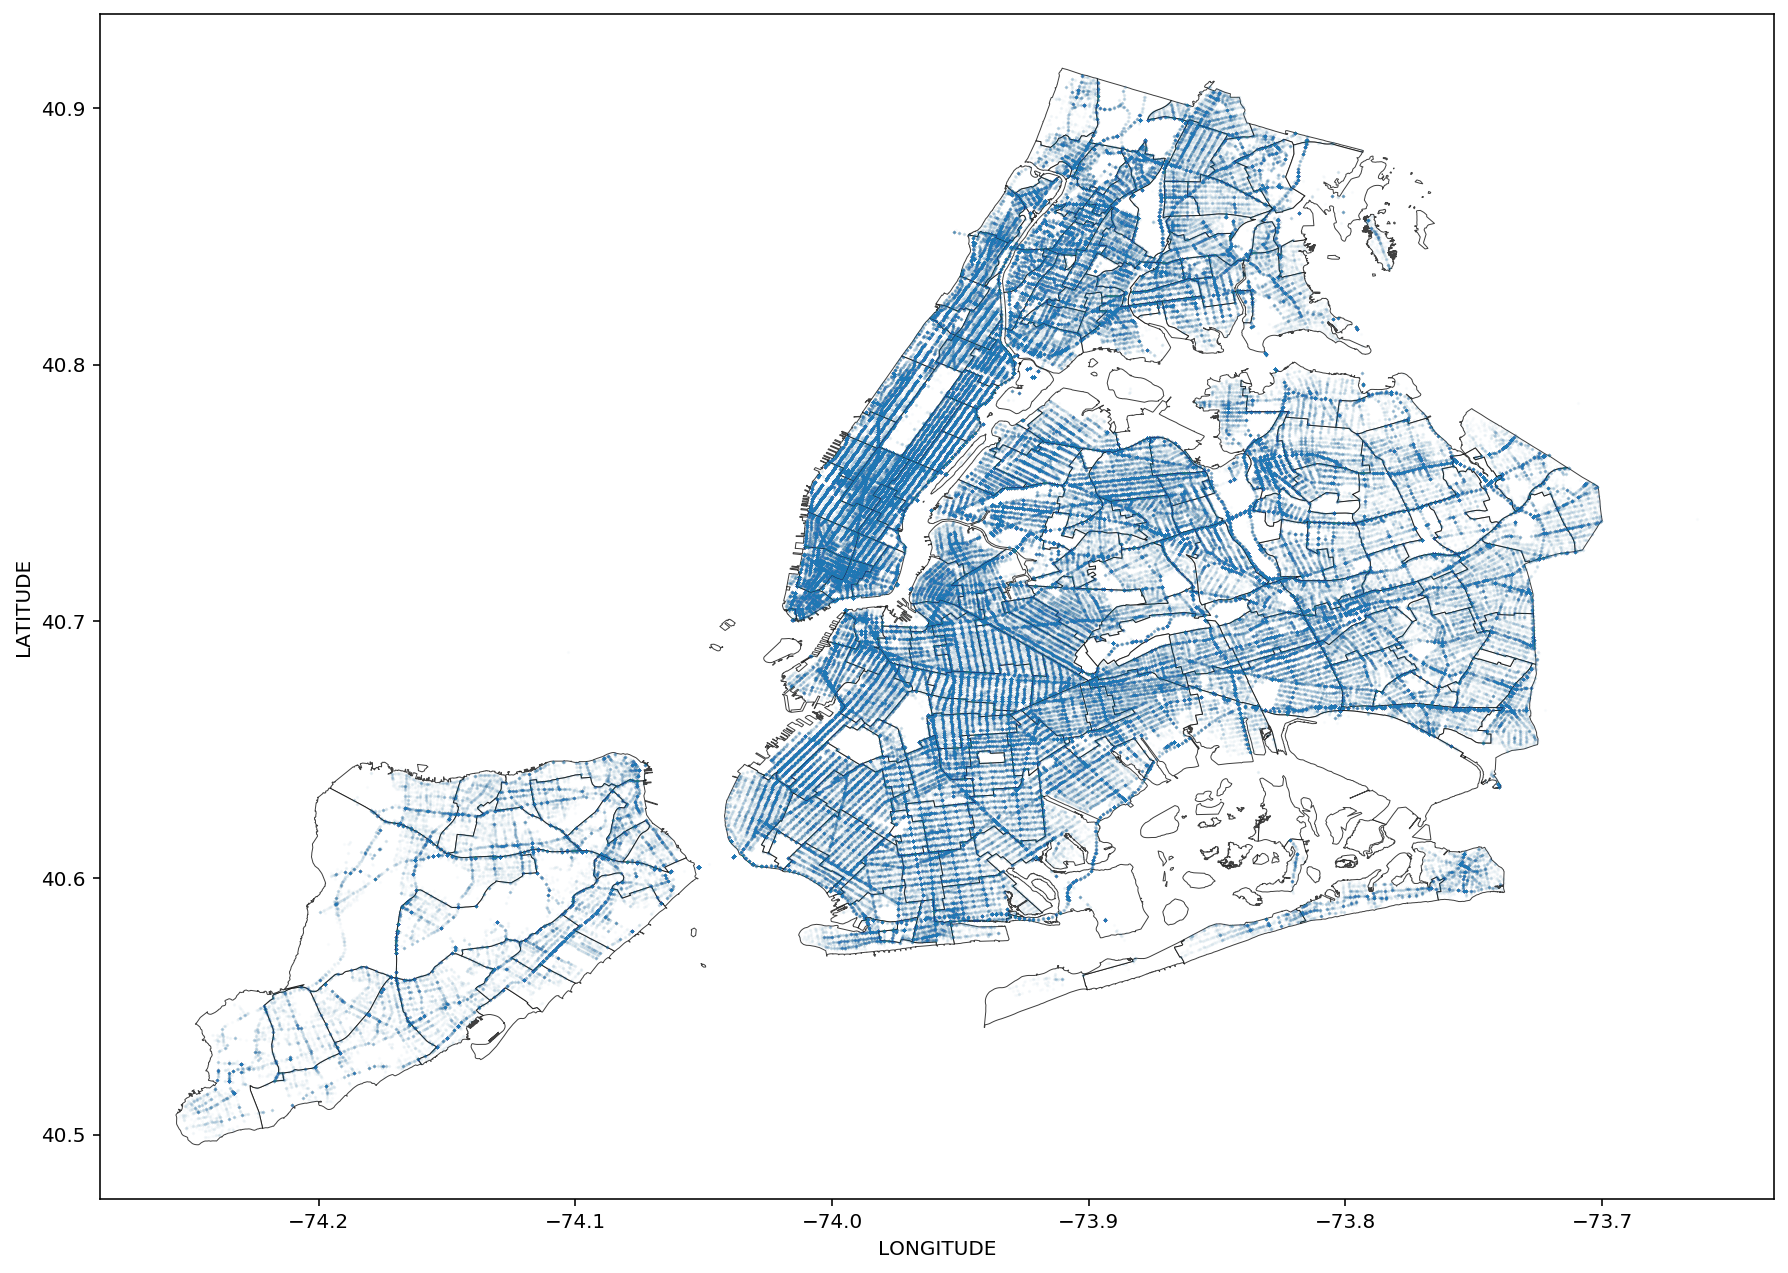

In [111]:
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(15, 15),
    alpha=0.75)

scatterplot = final_df.plot(
    kind='scatter',
    x='LONGITUDE',
    y='LATITUDE',
    s=0.5,
    alpha=0.02,
    ax=base)

In [112]:
final_df.to_csv('collisions.csv.gz', index=False, compression='gzip')

In [113]:
# 4050018: Panos :-)
final_df.query('UNIQUE_KEY  == "4050018"').T

116837
UNIQUE_KEY                                              4050018
DATETIME                                    2018-12-21 20:10:00
LATITUDE                                                40.7428
LONGITUDE                                              -74.0077
ZIPCODE                                                   10011
NEIGHBORHOOD         Hudson Yards-Chelsea-Flatiron-Union Square
BOROUGH                                               Manhattan
PERSONS_INJURED                                               0
PERSONS_KILLED                                                0
PEDESTRIANS_INJURED                                           0
PEDESTRIANS_KILLED                                            0
CYCLISTS_INJURED                                              0
CYCLISTS_KILLED                                               0
MOTORISTS_INJURED                                             0
MOTORISTS_KILLED                                              0
ON_STREET_NAME                 10 AVENUE                       
CROSS_STREET_NAME                                WEST 15 STREET
OFF_STREET_NAME                                             NaN
REPORTED_ZIPCODE                                          10011
REPORTED_BOROUGH                                      MANHATTAN

## Contributing factor and Vehicle type

* Examine the contents of Contributing factor and Vehicle type. Replace noisy values with UNSPECIFIED

* Add a column "NUM_VEHICLES" to show the number of vehicles involved in the accident. Check that we do not have NaNs before a real value in CAUSE and in VEHICLE TYPE, and that the two columns (CAUSE AND VEHICLE) agree in the number.

In [114]:
ct_df

CAUSE                    VEHICLE_TYPE  \
UNIQUE_KEY                                                                   
100                            UNSPECIFIED               PASSENGER VEHICLE   
100                            UNSPECIFIED               PASSENGER VEHICLE   
1000                           UNSPECIFIED               PASSENGER VEHICLE   
1000                           UNSPECIFIED                         UNKNOWN   
10000                          UNSPECIFIED                            TAXI   
10000                          UNSPECIFIED                            TAXI   
100000                         UNSPECIFIED               PASSENGER VEHICLE   
100000                         UNSPECIFIED  LARGE COM VEH(6 OR MORE TIRES)   
1000000                        UNSPECIFIED               PASSENGER VEHICLE   
1000000                        UNSPECIFIED               PASSENGER VEHICLE   
1000001     DRIVER INATTENTION/DISTRACTION               PASSENGER VEHICLE   
1000001                        UNSPECIFIED               PASSENGER VEHICLE   
1000002                        UNSPECIFIED               PASSENGER VEHICLE   
1000002                        UNSPECIFIED               PASSENGER VEHICLE   
1000003                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000003                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000004                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000004                        UNSPECIFIED               PASSENGER VEHICLE   
1000005            PRESCRIPTION MEDICATION               PASSENGER VEHICLE   
1000005                        UNSPECIFIED               PASSENGER VEHICLE   
1000006                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000006                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000007     DRIVER INATTENTION/DISTRACTION               PASSENGER VEHICLE   
1000008                        UNSPECIFIED   SPORT UTILITY / STATION WAGON   
1000008                        UNSPECIFIED         SMALL COM VEH(4 TIRES)    
1000009                   BACKING UNSAFELY   SPORT UTILITY / STATION WAGON   
1000009                        UNSPECIFIED               PASSENGER VEHICLE   
100001                         UNSPECIFIED               PASSENGER VEHICLE   
100001                         UNSPECIFIED               PASSENGER VEHICLE   
100001                         UNSPECIFIED               PASSENGER VEHICLE   
...                                    ...                             ...   
999985                     FATIGUED/DROWSY               PASSENGER VEHICLE   
999985                     FATIGUED/DROWSY               PASSENGER VEHICLE   
999986                         UNSPECIFIED                           OTHER   
999986                         UNSPECIFIED               PASSENGER VEHICLE   
999988      DRIVER INATTENTION/DISTRACTION               PASSENGER VEHICLE   
999988      DRIVER INATTENTION/DISTRACTION   SPORT UTILITY / STATION WAGON   
999989                  TURNING IMPROPERLY               PASSENGER VEHICLE   
999989                  TURNING IMPROPERLY   SPORT UTILITY / STATION WAGON   
99999                          UNSPECIFIED               PASSENGER VEHICLE   
99999                          UNSPECIFIED               PASSENGER VEHICLE   
999990      DRIVER INATTENTION/DISTRACTION   SPORT UTILITY / STATION WAGON   
999990      DRIVER INATTENTION/DISTRACTION               PASSENGER VEHICLE   
999991      DRIVER INATTENTION/DISTRACTION  LARGE COM VEH(6 OR MORE TIRES)   
999991      DRIVER INATTENTION/DISTRACTION                         UNKNOWN   
999992       FAILURE TO YIELD RIGHT-OF-WAY   SPORT UTILITY / STATION WAGON   
999992                         UNSPECIFIED                         UNKNOWN   
999993                         UNSPECIFIED               PASSENGER VEHICLE   
999993                         UNSPECIFIED                         UNKNOWN   
999994                         UNSPECIFIED   SPORT UTILITY 

In [115]:
len(set(ct_df.index) - set(final_df.UNIQUE_KEY.values))

346

In [116]:
ct_df.CAUSE.value_counts()

UNSPECIFIED                                              1732349
DRIVER INATTENTION/DISTRACTION                            345551
FAILURE TO YIELD RIGHT-OF-WAY                              98880
FOLLOWING TOO CLOSELY                                      86319
OTHER VEHICULAR                                            75829
BACKING UNSAFELY                                           64436
FATIGUED/DROWSY                                            58643
TURNING IMPROPERLY                                         46756
PASSING OR LANE USAGE IMPROPER                             42266
PASSING TOO CLOSELY                                        36689
UNSAFE LANE CHANGING                                       32802
TRAFFIC CONTROL DISREGARDED                                28435
DRIVER INEXPERIENCE                                        27612
LOST CONSCIOUSNESS                                         24784
PAVEMENT SLIPPERY                                          19289
PRESCRIPTION MEDICATION  

In [117]:
# We replace noisy causes with UNSPECIFIED and not with NaN, as NaN is used to mean "no vehicle"
import numpy as np
ct_df.CAUSE = ct_df.CAUSE.replace(to_replace='1', value='UNSPECIFIED')
ct_df.CAUSE = ct_df.CAUSE.replace(to_replace='80', value='UNSPECIFIED')
ct_df.CAUSE = ct_df.CAUSE.replace(to_replace='ILLNES', value='ILLNESS')

In [124]:
ct_df.VEHICLE_TYPE.value_counts()

PASSENGER VEHICLE                 1295519
SPORT UTILITY / STATION WAGON      756170
SEDAN                              226395
UNKNOWN                            152986
TAXI                               116843
PICK-UP TRUCK                       64820
VAN                                 57753
BICYCLE                             40425
BUS                                 39777
SMALL COM VEH(4 TIRES)              30074
LARGE COM VEH(6 OR MORE TIRES)      28228
LIVERY VEHICLE                      19126
MOTORCYCLE                          15436
BOX TRUCK                           14044
TRACTOR TRUCK                        6451
AMBULANCE                            5943
TRUCK                                5703
DUMP TRUCK                           2754
CONVERTIBLE                          2494
SANITATION                           2092
FIRE TRUCK                           1824
GARBAGE OR REFUSE                    1162
SCOOTER                              1030
CARRY ALL                         

In [119]:
# Also consult https://data.ny.gov/api/assets/83055271-29A6-4ED4-9374-E159F30DB5AE

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='STATION WAGON/SPORT UTILITY VEHICLE', value='SPORT UTILITY / STATION WAGON')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SUBN', value='SPORT UTILITY / STATION WAGON')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SUBN/', value='SPORT UTILITY / STATION WAGON')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='WAGON', value='SPORT UTILITY / STATION WAGON')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BU', value='BUS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BS', value='BUS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SCHOOL BUS', value='BUS')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='P/SH', value='POWER SHOVEL')



ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MULTI-WHEELED VEHICLE', value='LARGE COM VEH(6 OR MORE TIRES)')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SMALL', value='SMALL COM VEH(4 TIRES)')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SMALL COM VEH(4 TIRES) ', value='SMALL COM VEH(4 TIRES)')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='LIVER', value='LIVERY VEHICLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='LIMOU', value='LIVERY VEHICLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='LIMO', value='LIVERY VEHICLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='LIMO/', value='LIVERY VEHICLE')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FORKL', value='FORK LIFT')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FORK', value='FORK LIFT')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DUMP', value='DUMP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DUMPS', value='DUMP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DUMPT', value='DUMP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PUMP', value='DUMP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DP', value='DUMP TRUCK')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='GARBA', value='GARBAGE OR REFUSE')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='CONV', value='CONVERTIBLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='CONVE', value='CONVERTIBLE')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SP', value='SNOW PLOW')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='2 DR SEDAN', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='4 DR SEDAN', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SUDAN', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SE', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='4DS', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='4DSD', value='SEDAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='3-DOOR', value='SEDAN')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN CAMPER', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN T', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN F', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN A', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN W', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN/B', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAB', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VANG', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN C', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN/T', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VANETTE', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN`', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAV', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VN', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='VAN (', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='ENCLOSED BODY - REMOVABLE ENCLOSURE', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='ENCLOSED BODY - NONREMOVABLE ENCLOSURE', value='VAN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='ENCLO', value='VAN')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOTOR HOME', value='R/V')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOTORIZED HOME', value='R/V')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='RV', value='R/V')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='R/V C', value='R/V')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='RV/TR', value='R/V')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='H/WH', value='R/V') # house on wheels


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AM', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AMB', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AMBU', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AMBUL', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='ANBUL', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AMABU', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='AMULA', value='AMBULANCE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='ABULA', value='AMBULANCE')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BICYC', value='BICYCLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BIKE', value='BICYCLE')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TANK', value='TANK TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TANKE', value='TANK TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TANKER', value='TANK TRUCK')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='OTHER', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNK', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNK,', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNKN', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNKNO', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNKNOWN', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNKOW', value='UNKNOWN')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='UNNKO', value='UNKNOWN')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SC', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SCOO', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SCOOT', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOTER', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOPD', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOPAD', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOPET', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOPEN', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='E BIK', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='E-BIK', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='E/BIK', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MINIBIKE', value='SCOOTER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOPED', value='SCOOTER')



ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='US PO', value='USPS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='USPOS', value='USPS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='USPS2', value='USPS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='USPST', value='USPS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='U.S P', value='USPS')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='U.S.', value='USPS')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMME', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COM', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMM', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COM T', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COM.', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMMM', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMER', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMMM', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COM.', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMIX', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMPA', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMB', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMMU', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='COMM.', value='COMMERCIAL')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='C0MME', value='COMMERCIAL')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PASS', value='PASSENGER VEHICLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PAS', value='PASSENGER VEHICLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PASSE', value='PASSENGER VEHICLE')



ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PEDIC', value='PEDICAB')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOW T', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOW', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOW TRUCK', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOWTR', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOW-T', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOWIN', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TOWER', value='TOW TRUCK / WRECKER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='G TOW', value='TOW TRUCK / WRECKER')



ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TKP', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PK', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PICK', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PICK-', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PICKU', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='PICKUP WITH MOUNTED CAMPER', value='PICK-UP TRUCK')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLAT BED', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLAT RACK', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLATB', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLAT', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLAT RACK', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FLATB', value='PICK-UP TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BACK', value='PICK-UP TRUCK')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FDNY', value='FIRE TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FIRE', value='FIRE TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FIRET', value='FIRE TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FD NY', value='FIRE TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FD TR', value='FIRE TRUCK')
 

    

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRACTOR TRUCK DIESEL', value='TRACTOR TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRACTOR TRUCK GASOLINE', value='TRACTOR TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRAC.', value='TRACTOR TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRAC', value='TRACTOR TRUCK')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRAIL', value='TRAILER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TR', value='TRAILER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRL', value='TRAILER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRAIL', value='TRAILER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRLR', value='TRAILER')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SEMI', value='TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SEMI-', value='TRUCK')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MACK', value='TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TK', value='TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRACT', value='TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRK', value='TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='TRACK', value='TRUCK')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='FB', value='BOX TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BOX T', value='BOX TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BOX', value='BOX TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='BOXTR', value='BOX TRUCK')


ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOTOR', value='MOTORCYCLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MINICYCLE', value='MOTORCYCLE')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='MOTORBIKE', value='MOTORCYCLE')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DSNY', value='SANITATION')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DS', value='SANITATION')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='SANIT', value='SANITATION')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DELV', value='DELIVERY TRUCK')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='DEL', value='DELIVERY TRUCK')

ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='RD/S', value='ROAD SWEEPER')
ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace='OML/', value='LIVERY VEHICLE') # OMNIBUS LIVERY





In [120]:
import ngram
import math
freq = ct_df.VEHICLE_TYPE.value_counts()
vtypes = set(ct_df.VEHICLE_TYPE.values)

similarities = []
for t1 in vtypes:
    for t2 in vtypes:
        s = ngram.NGram.compare(t1, t2, n=2)
        f1 = freq.loc[t1]
        f2 = freq.loc[t2]
        r = abs(math.log10(f1/f2))
        f = f1 + f2
        if f2 > f1:
            fr1 = f2
            fr2 = f1
            tp1 = t2
            tp2 = t1
        else:
            fr1 = f1
            fr2 = f2
            tp1 = t1
            tp2 = t2
            
        sim = {
            "t1" : tp1,
            "f1" : fr1,
            "t2" : tp2,
            "f2" : fr2,
            "sim" : s,
            "ratio" : r
        }
            
        if t1>t2 and s>0.1 and f > 1000 and r>1.5 and min(f1,f2)<200:
            similarities.append(sim)

pd.DataFrame(similarities).sort_values('sim', ascending=False)

f1   f2     ratio       sim                      t1              t2
114   14044  159  1.946094  0.350000               BOX TRUCK  BEVERAGE TRUCK
68     2754   26  2.024991  0.333333              DUMP TRUCK  DELIVERY TRUCK
115   14044  176  1.901978  0.300000               BOX TRUCK   ARMORED TRUCK
37     5703  176  1.510591  0.294118                   TRUCK   ARMORED TRUCK
122   14044   26  2.732517  0.285714               BOX TRUCK  DELIVERY TRUCK
36     5703  159  1.554706  0.277778                   TRUCK  BEVERAGE TRUCK
44     5703   26  2.341130  0.277778                   TRUCK  DELIVERY TRUCK
48     1824   26  1.846051  0.272727              FIRE TRUCK  DELIVERY TRUCK
11    64820  176  2.566196  0.250000           PICK-UP TRUCK   ARMORED TRUCK
86     6451  176  1.564114  0.250000           TRACTOR TRUCK   ARMORED TRUCK
12    64820   26  3.396736  0.240000           PICK-UP TRUCK  DELIVERY TRUCK
88     6451   26  2.394654  0.240000           TRACTOR TRUCK  DELIVERY TRUCK
10    64820  159  2.610312  0.240000           PICK-UP TRUCK  BEVERAGE TRUCK
84     6451  159  1.608230  0.240000           TRACTOR TRUCK  BEVERAGE TRUCK
20     1030    5  2.313867  0.230769                 SCOOTER           INTER
30     1030    5  2.313867  0.230769                 SCOOTER           CATER
118   14044    1  4.147491  0.200000               BOX TRUCK           BLOCK
40     5703    2  3.455073  0.200000                   TRUCK             TRT
55    39777    8  3.696542  0.200000                     BUS           BULLD
60    39777    4  3.997572  0.200000                     BUS           BUCKE
74   226395    1  5.354867  0.200000                   SEDAN             SBN
51    39777    1  4.599632  0.200000                     BUS           BUDGE
76   226395    1  5.354867  0.200000                   SEDAN             SEA
71     1824    1  3.261025  0.187500              FIRE TRUCK           FRE T
4      2092    1  3.320562  0.187500              SANITATION           SANTA
63    15436    1  4.188535  0.187500              MOTORCYCLE           MOT S
97     2494    1  3.396896  0.187500             CONVERTIBLE            CONT
15    19126   26  2.866651  0.185185          LIVERY VEHICLE  DELIVERY TRUCK
39     5703    1  3.756103  0.181818                   TRUCK            TRAM
107  116843    1  5.067603  0.181818                    TAXI           TR/KI
..      ...  ...       ...       ...                     ...             ...
17    15436    4  3.586475  0.117647              MOTORCYCLE           MOVIN
62    15436    1  4.188535  0.117647              MOTORCYCLE           ME/BE
47     1824    1  3.261025  0.117647              FIRE TRUCK           BLOCK
35     5703    6  2.977952  0.117647                   TRUCK      GLASS RACK
98     2494    1  3.396896  0.117647             CONVERTIBLE            CATE
92     2092    1  3.320562  0.117647              SANITATION           2 TON
64    15436    1  4.188535  0.117647              MOTORCYCLE           MO PA
101    2494    3  2.919775  0.117647             CONVERTIBLE            CASE
79     6451    2  3.508597  0.111111           TRACTOR TRUCK             TRT
3      2494    1  3.396896  0.111111             CONVERTIBLE           PALLE
139   57753    1  4.761575  0.111111                     VAN             KEN
138   57753    1  4.761575  0.111111                     VAN             TCN
137   57753    1  4.761575  0.111111                     VAN             SBN
134   57753    1  4.761575  0.111111                     VAN             UKN
133   57753    1  4.761575  0.111111                     VAN             VOL
100    2494    1  3.396896  0.111111             CONVERTIBLE           CAMPE
130  116843    1  5.067603  0.111111                    TAXI              TE
6     39777    1  4.599632  0.111111                     BUS             RGS
80    39777    1  4.599632  0.111111                     BUS             OMS
126  116843  162  2.858088  0.111111                    TAXI              TN
58   

In [121]:
freq = ct_df.VEHICLE_TYPE.value_counts()

replace = freq [ freq <= 10]
for r in replace.index.values:
    ct_df.VEHICLE_TYPE = ct_df.VEHICLE_TYPE.replace(to_replace=r, value='UNKNOWN')


In [122]:
ct_df.to_csv('collisions-causes.csv.gz', index=False, compression='gzip')

In [123]:
t_end = datetime.now()

t_end

datetime.datetime(2019, 7, 14, 22, 13, 12, 555291)

In [125]:
t_end - t_start

datetime.timedelta(0, 899, 988805)